## Import packages

In [2]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [4]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [5]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [6]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [7]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts.reshape(len(log10masses) - 1, len(z_min))

## Plot the learned posterior
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

(Here I am just uploading posteriors from previous pydelfi runs)

In [8]:
import getdist
from getdist import plots, MCSamples
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import norm

## Load MCMC chains for two different data vectors

In [53]:
flat_samples = np.load('flat_samples_1000.npy')
flat_samples = [flat_samples]

In [54]:
mcmc_samples = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples)]

Removed no burn in


In [11]:
flat_samples_s = np.load('flat_samples_1000_seed1.npy')
flat_samples_s = [flat_samples_s]

In [12]:
mcmc_samples_s = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples_s)]

Removed no burn in


## Load the learned posterior from simulations with fine grid and compare it to MCMC results

# (1) Using interpolation

## (1.1) data vector = fiducial counts 
#### $N_{steps}$ = 1000

In [59]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


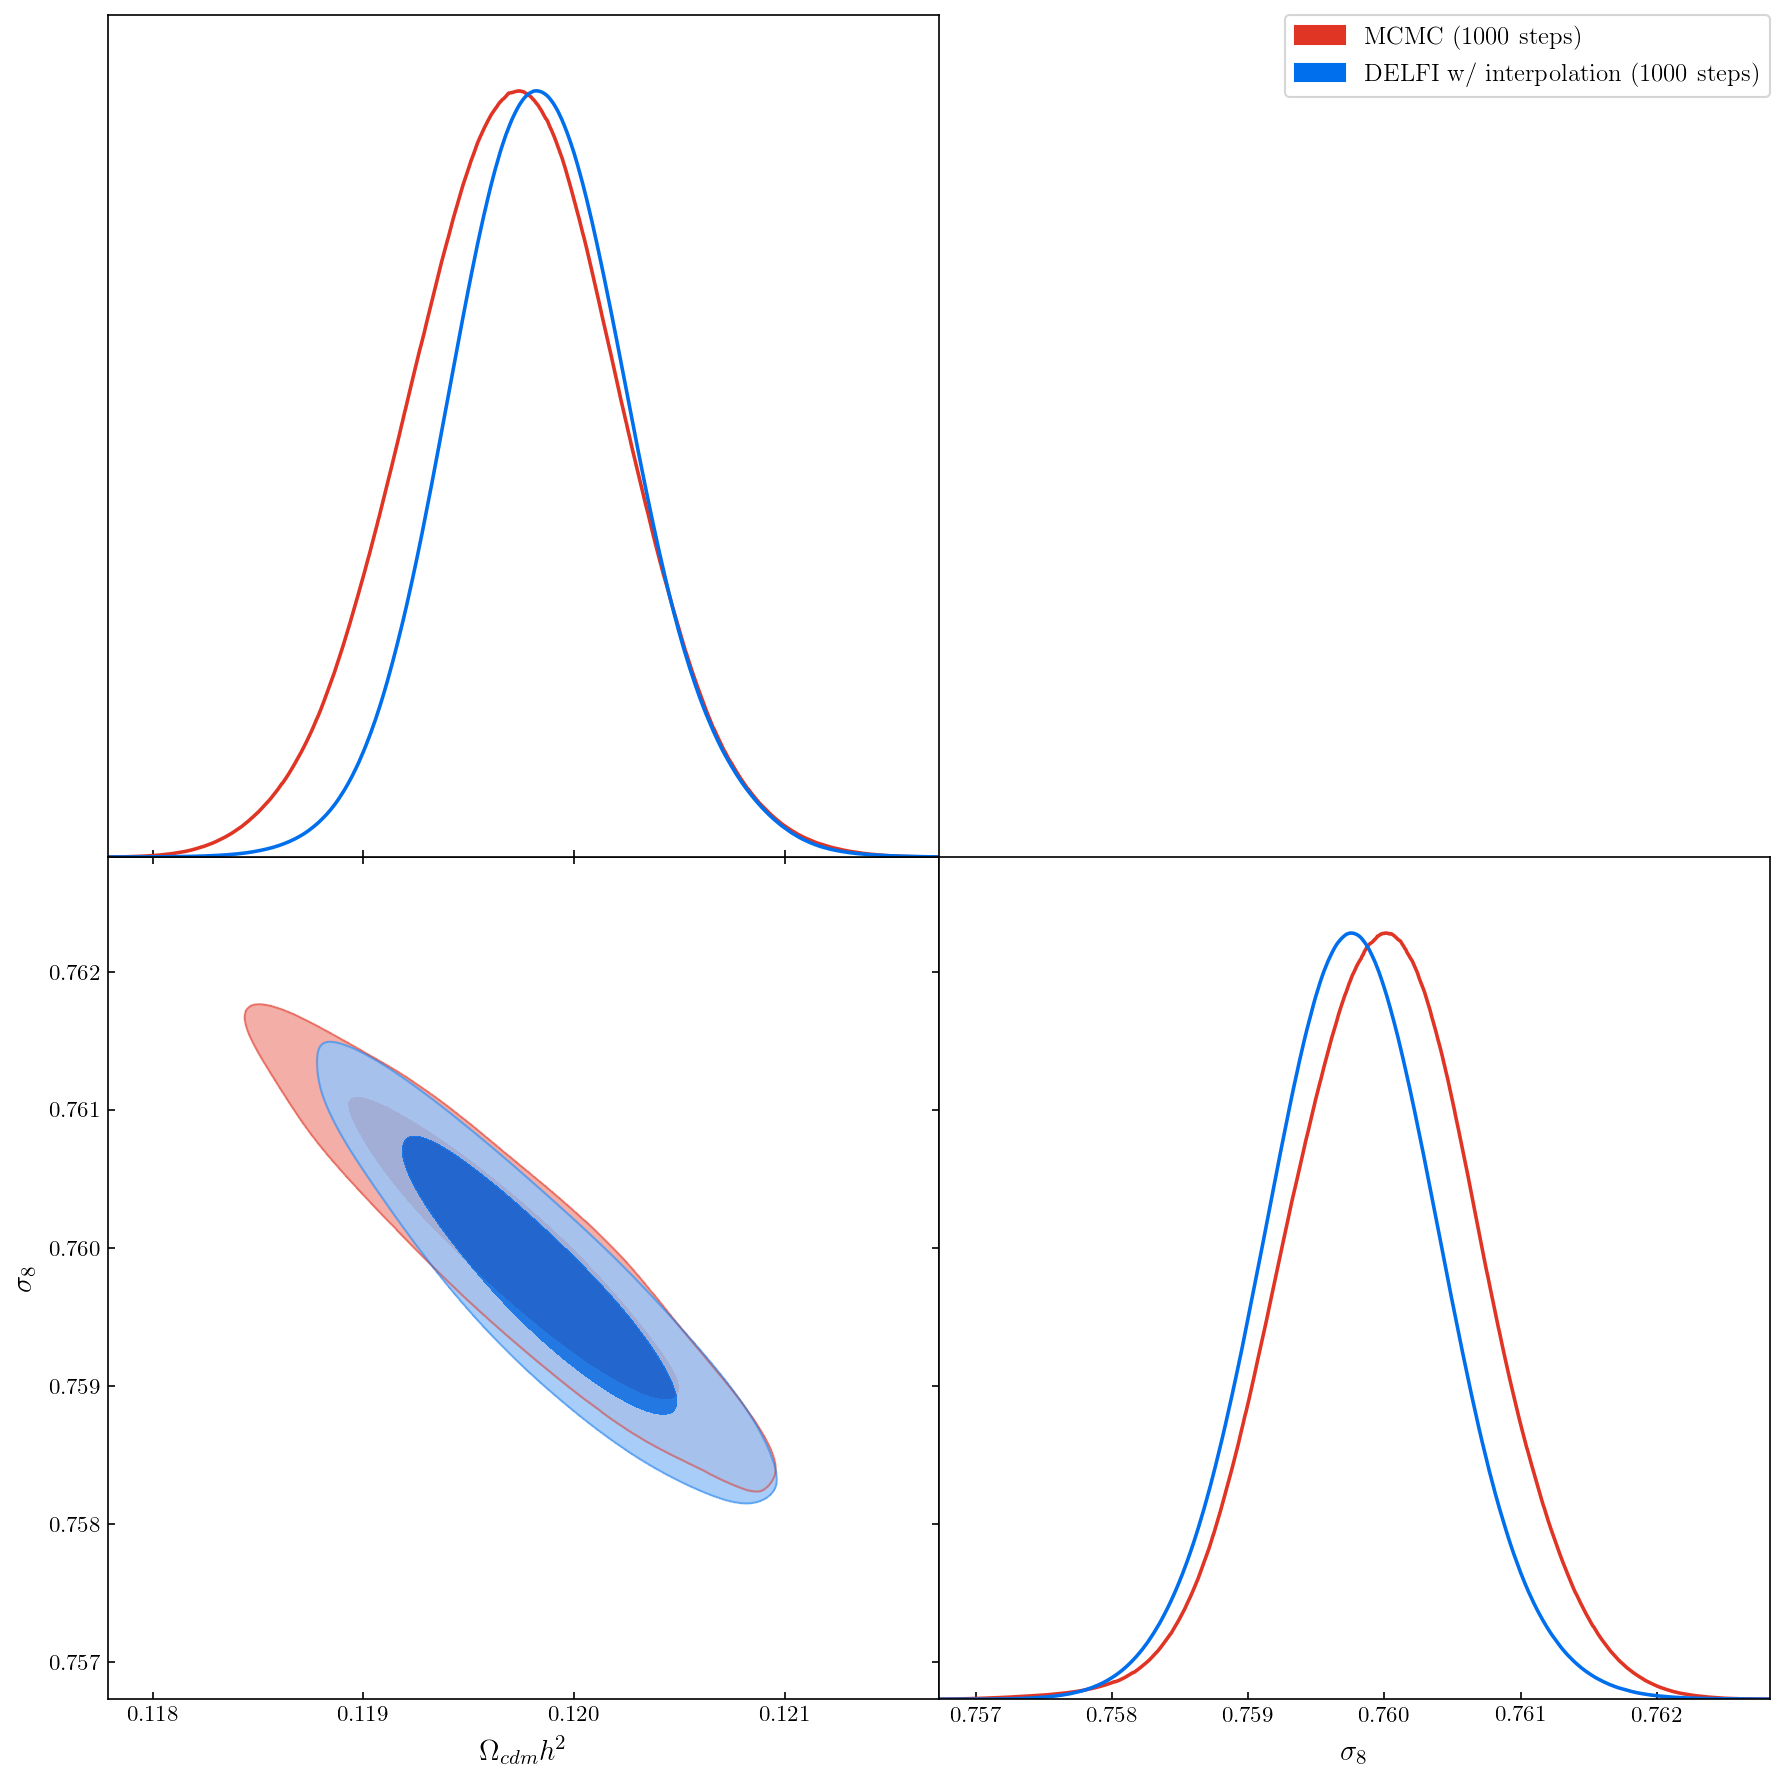

In [60]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI w/ interpolation (1000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### $N_{steps}$ = 2000

In [61]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp_2k/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp_2k/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


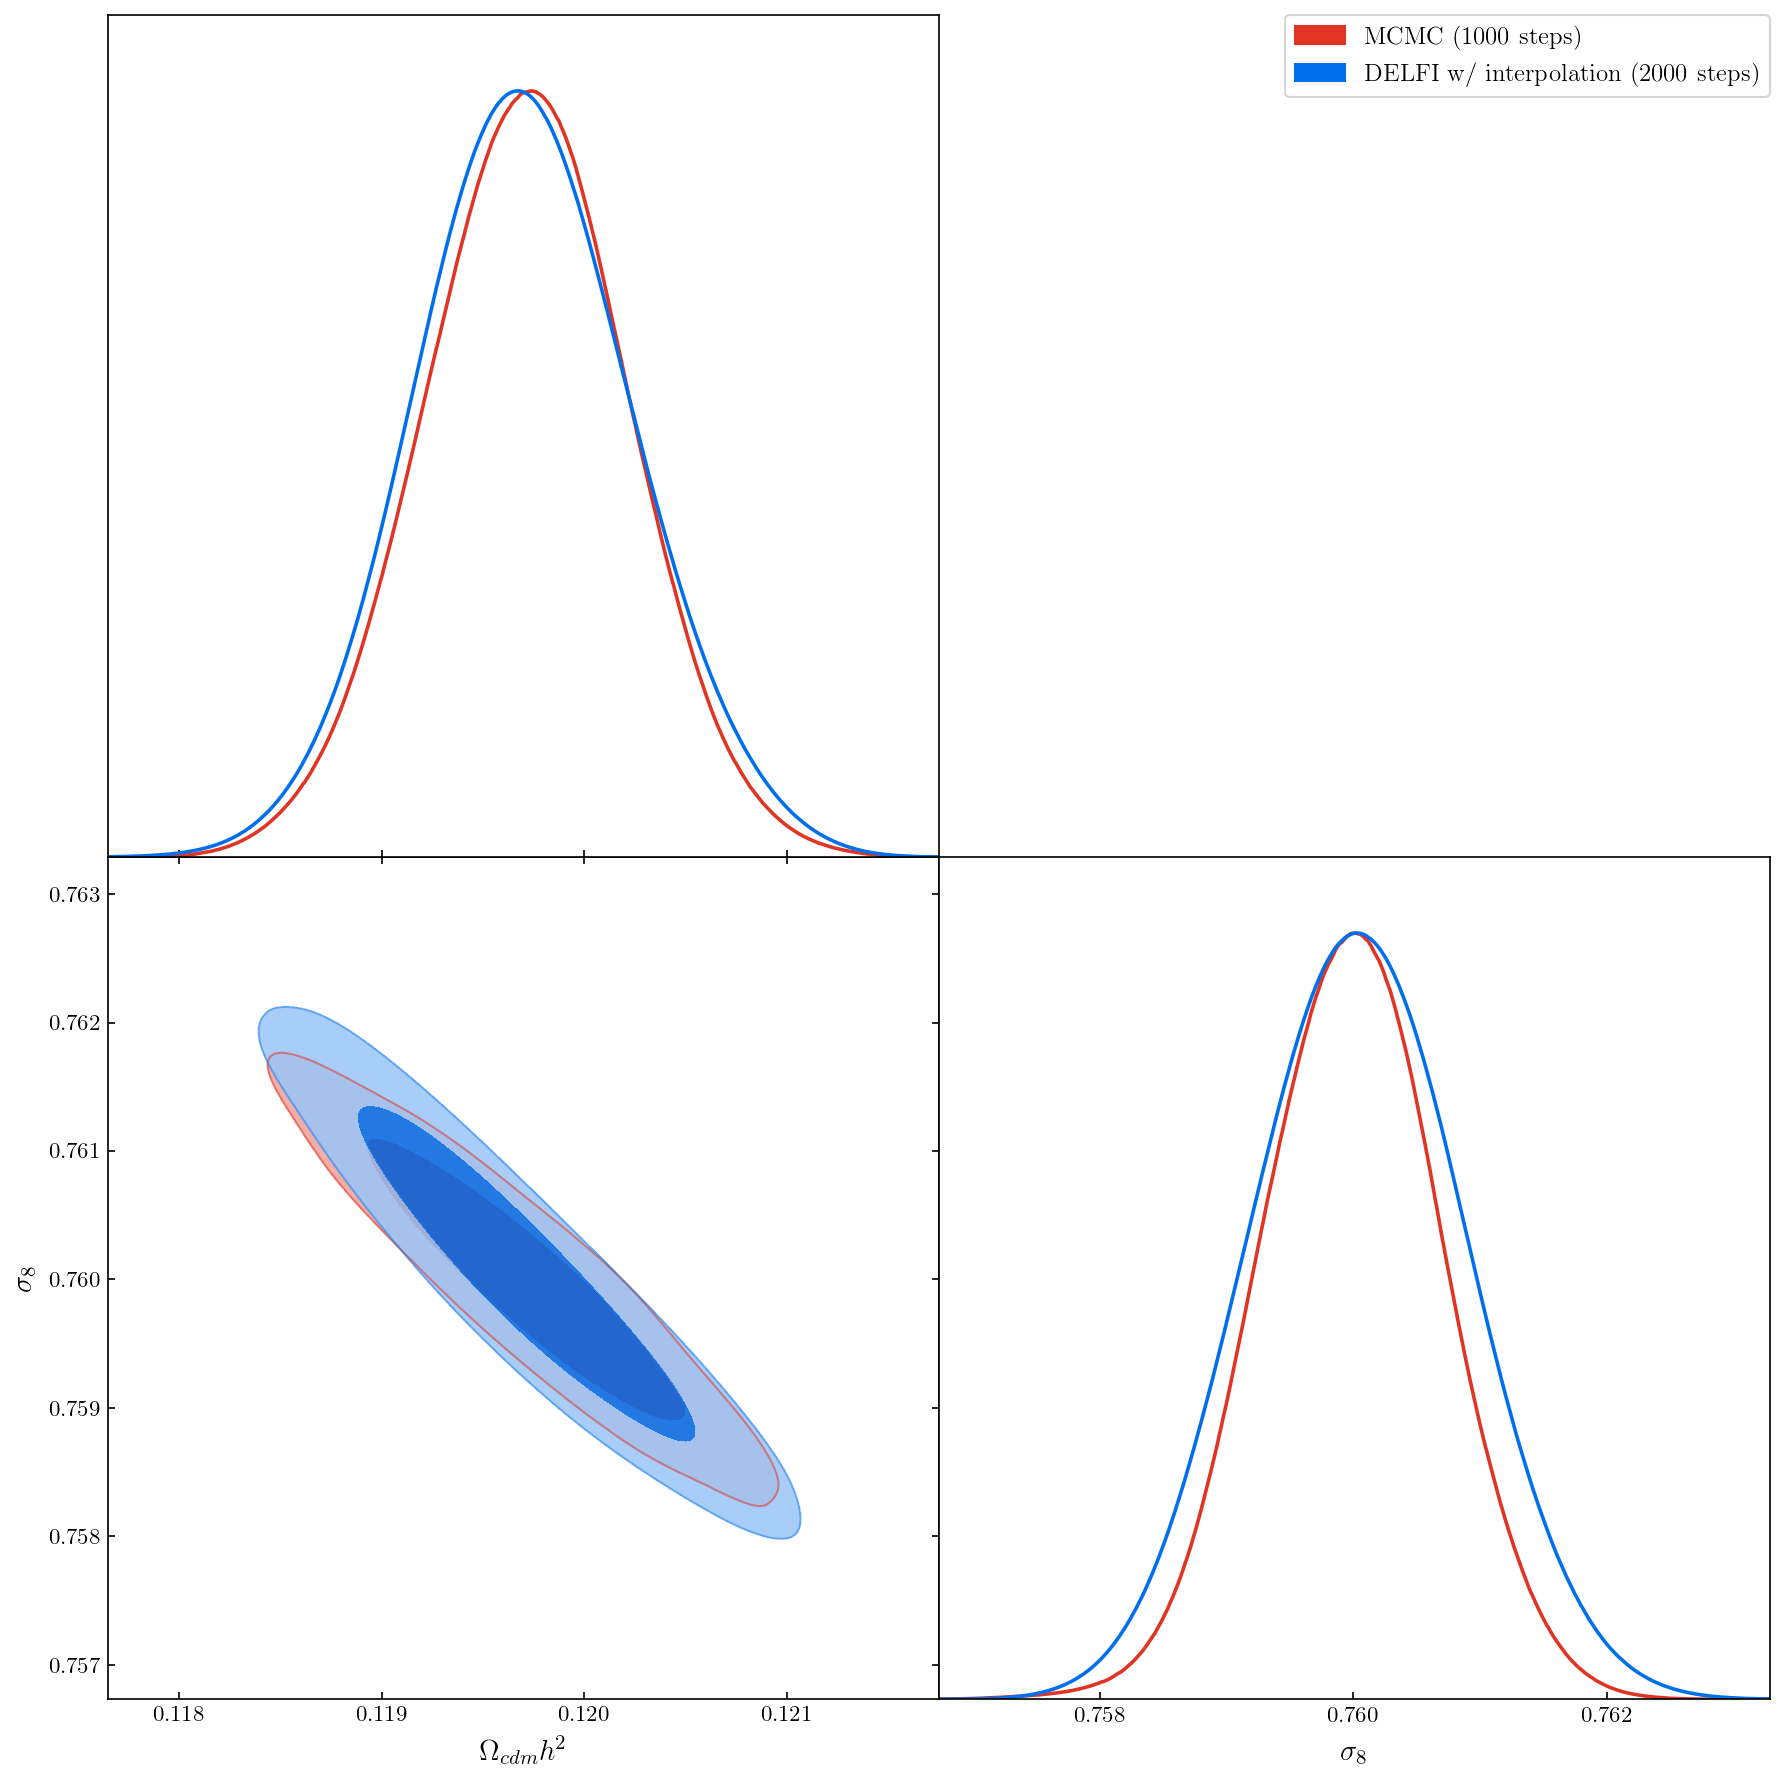

In [62]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI w/ interpolation (2000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### With fisher pretraining + data compression, $N_{steps}$ = 1000

In [63]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp_fisher_pretraining/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_interp_fisher_pretraining/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


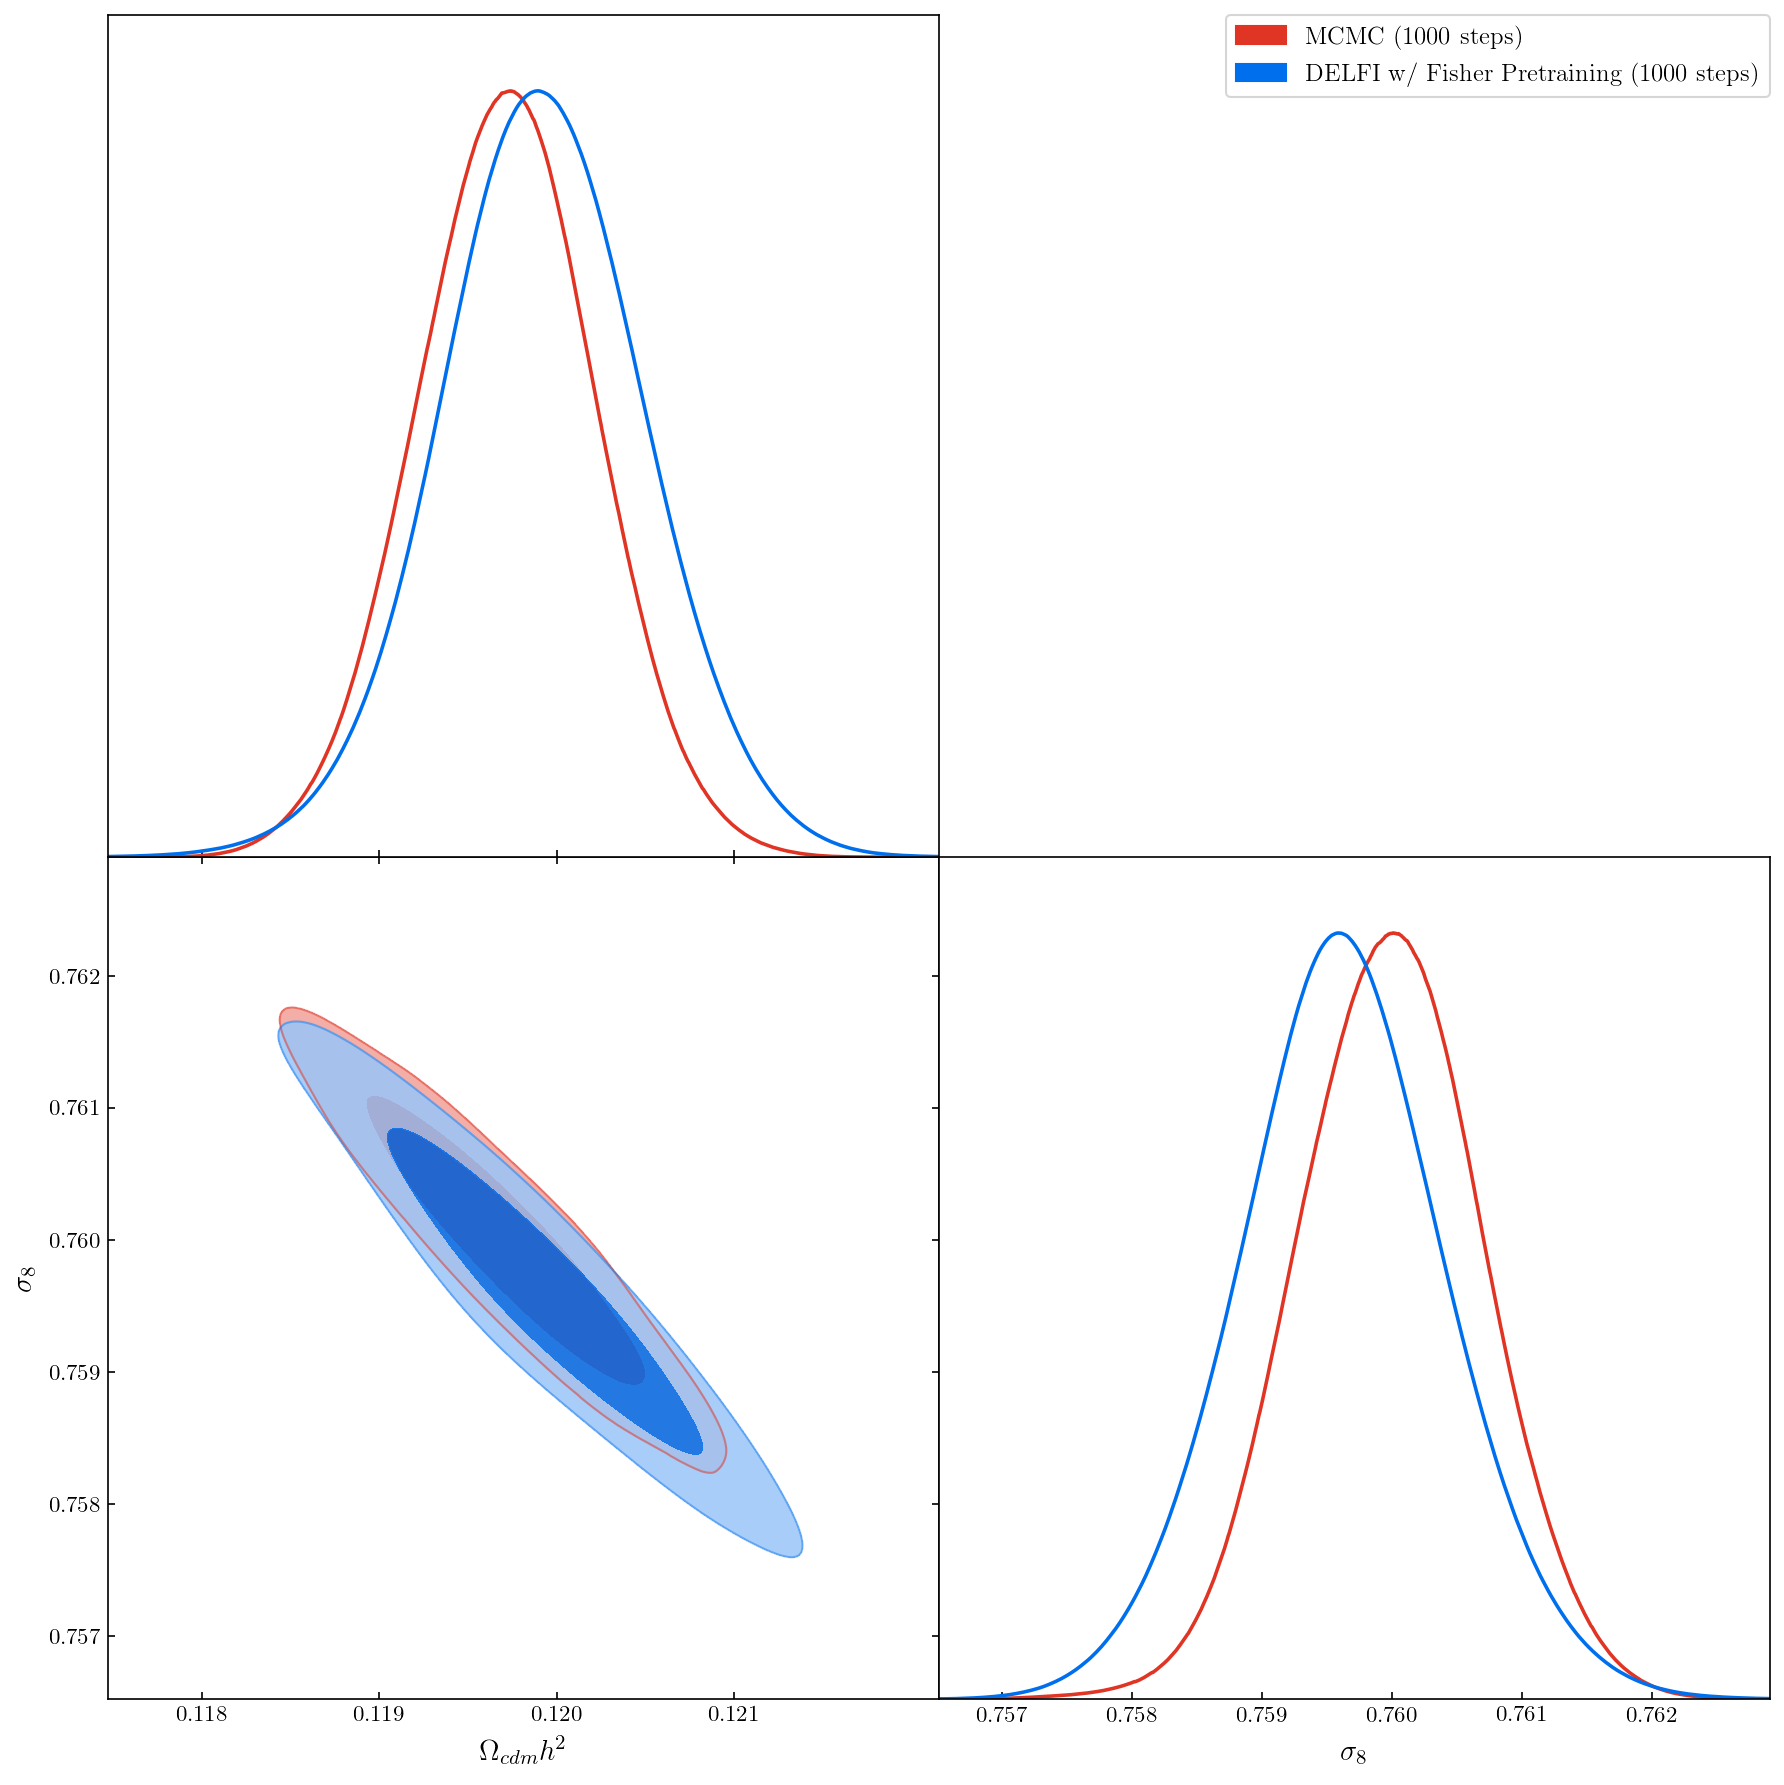

In [64]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI w/ Fisher Pretraining (1000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

## (1.2) data vector = poisson draw from fiducial values
#### $N_{steps}$ = 1000

In [25]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_2 = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_3/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_3/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_3 = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_4/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_4/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_4 = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_5/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_5/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_5 = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


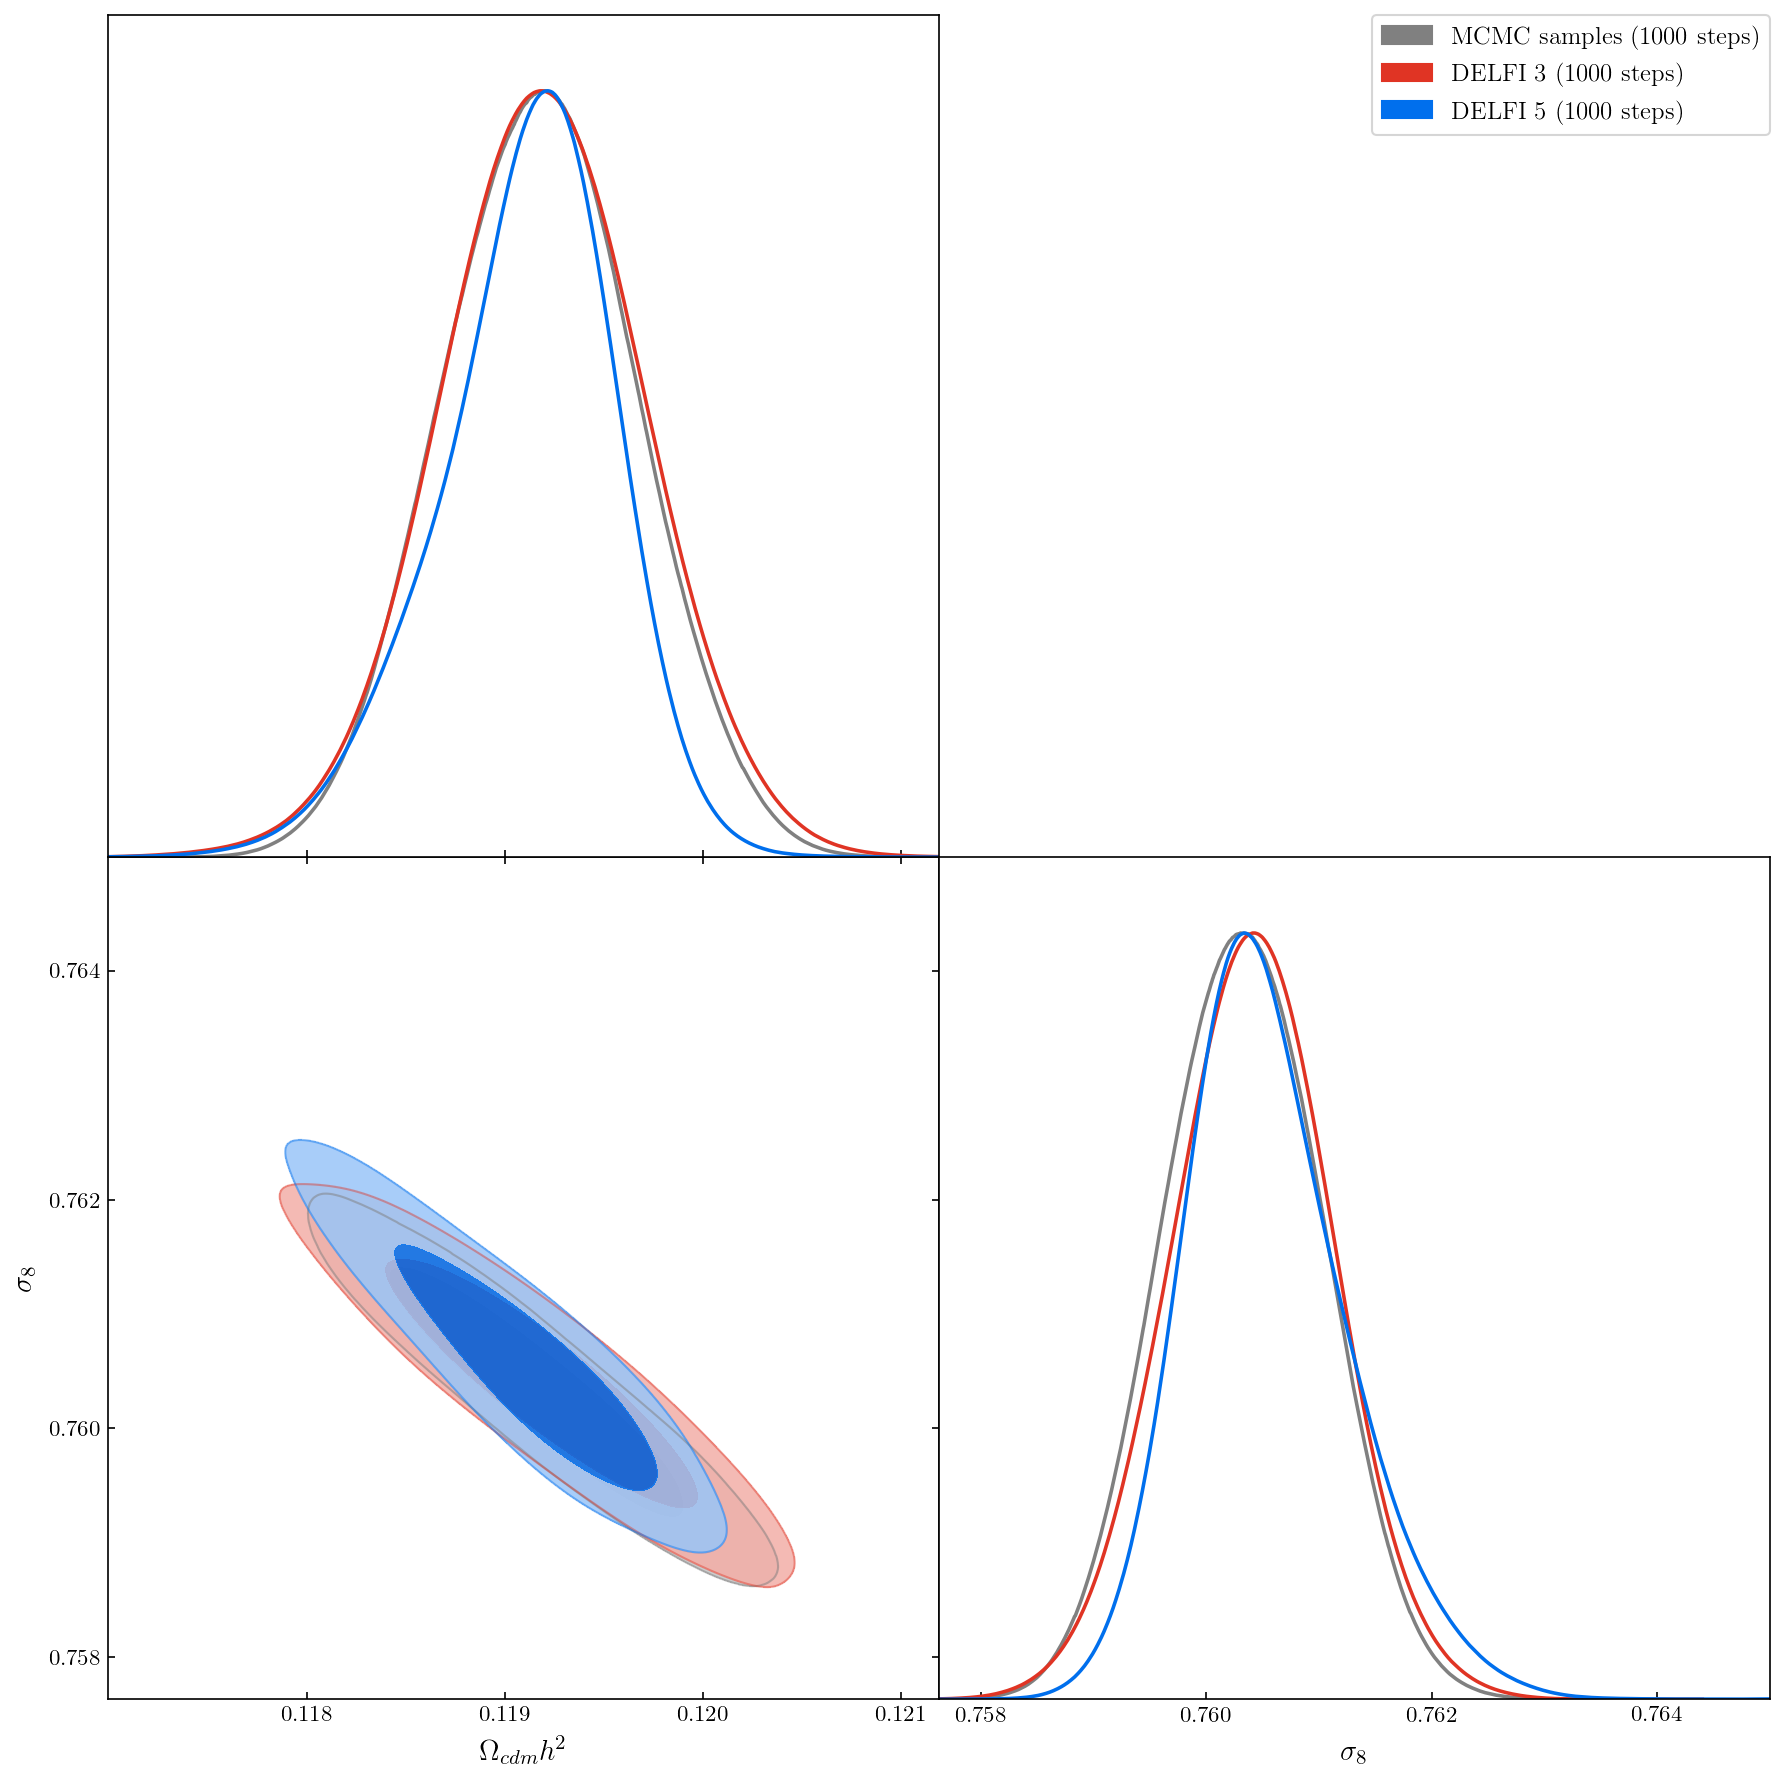

In [37]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0],
                 #delfi_samples[0], # <-- 1 and 2 look good, but not a bit of scatter is present
                 #delfi_samples_2[0], 
                 delfi_samples_3[0], # <-- looks good!
                 #delfi_samples_4[0], # <-- didn't converge too well
                 delfi_samples_5[0] # <--- looks good! 
                ], 
                legend_labels = ['MCMC samples (1000 steps)',
                    #'DELFI (1000 steps)', 
                    #'DELFI 2 (1000 steps)', 
                    'DELFI 3 (1000 steps)', 
                    #'DELFI 4 (1000 steps)', 
                    'DELFI 5 (1000 steps)'
                                ],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### $N_{steps}$ = 2000

In [65]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


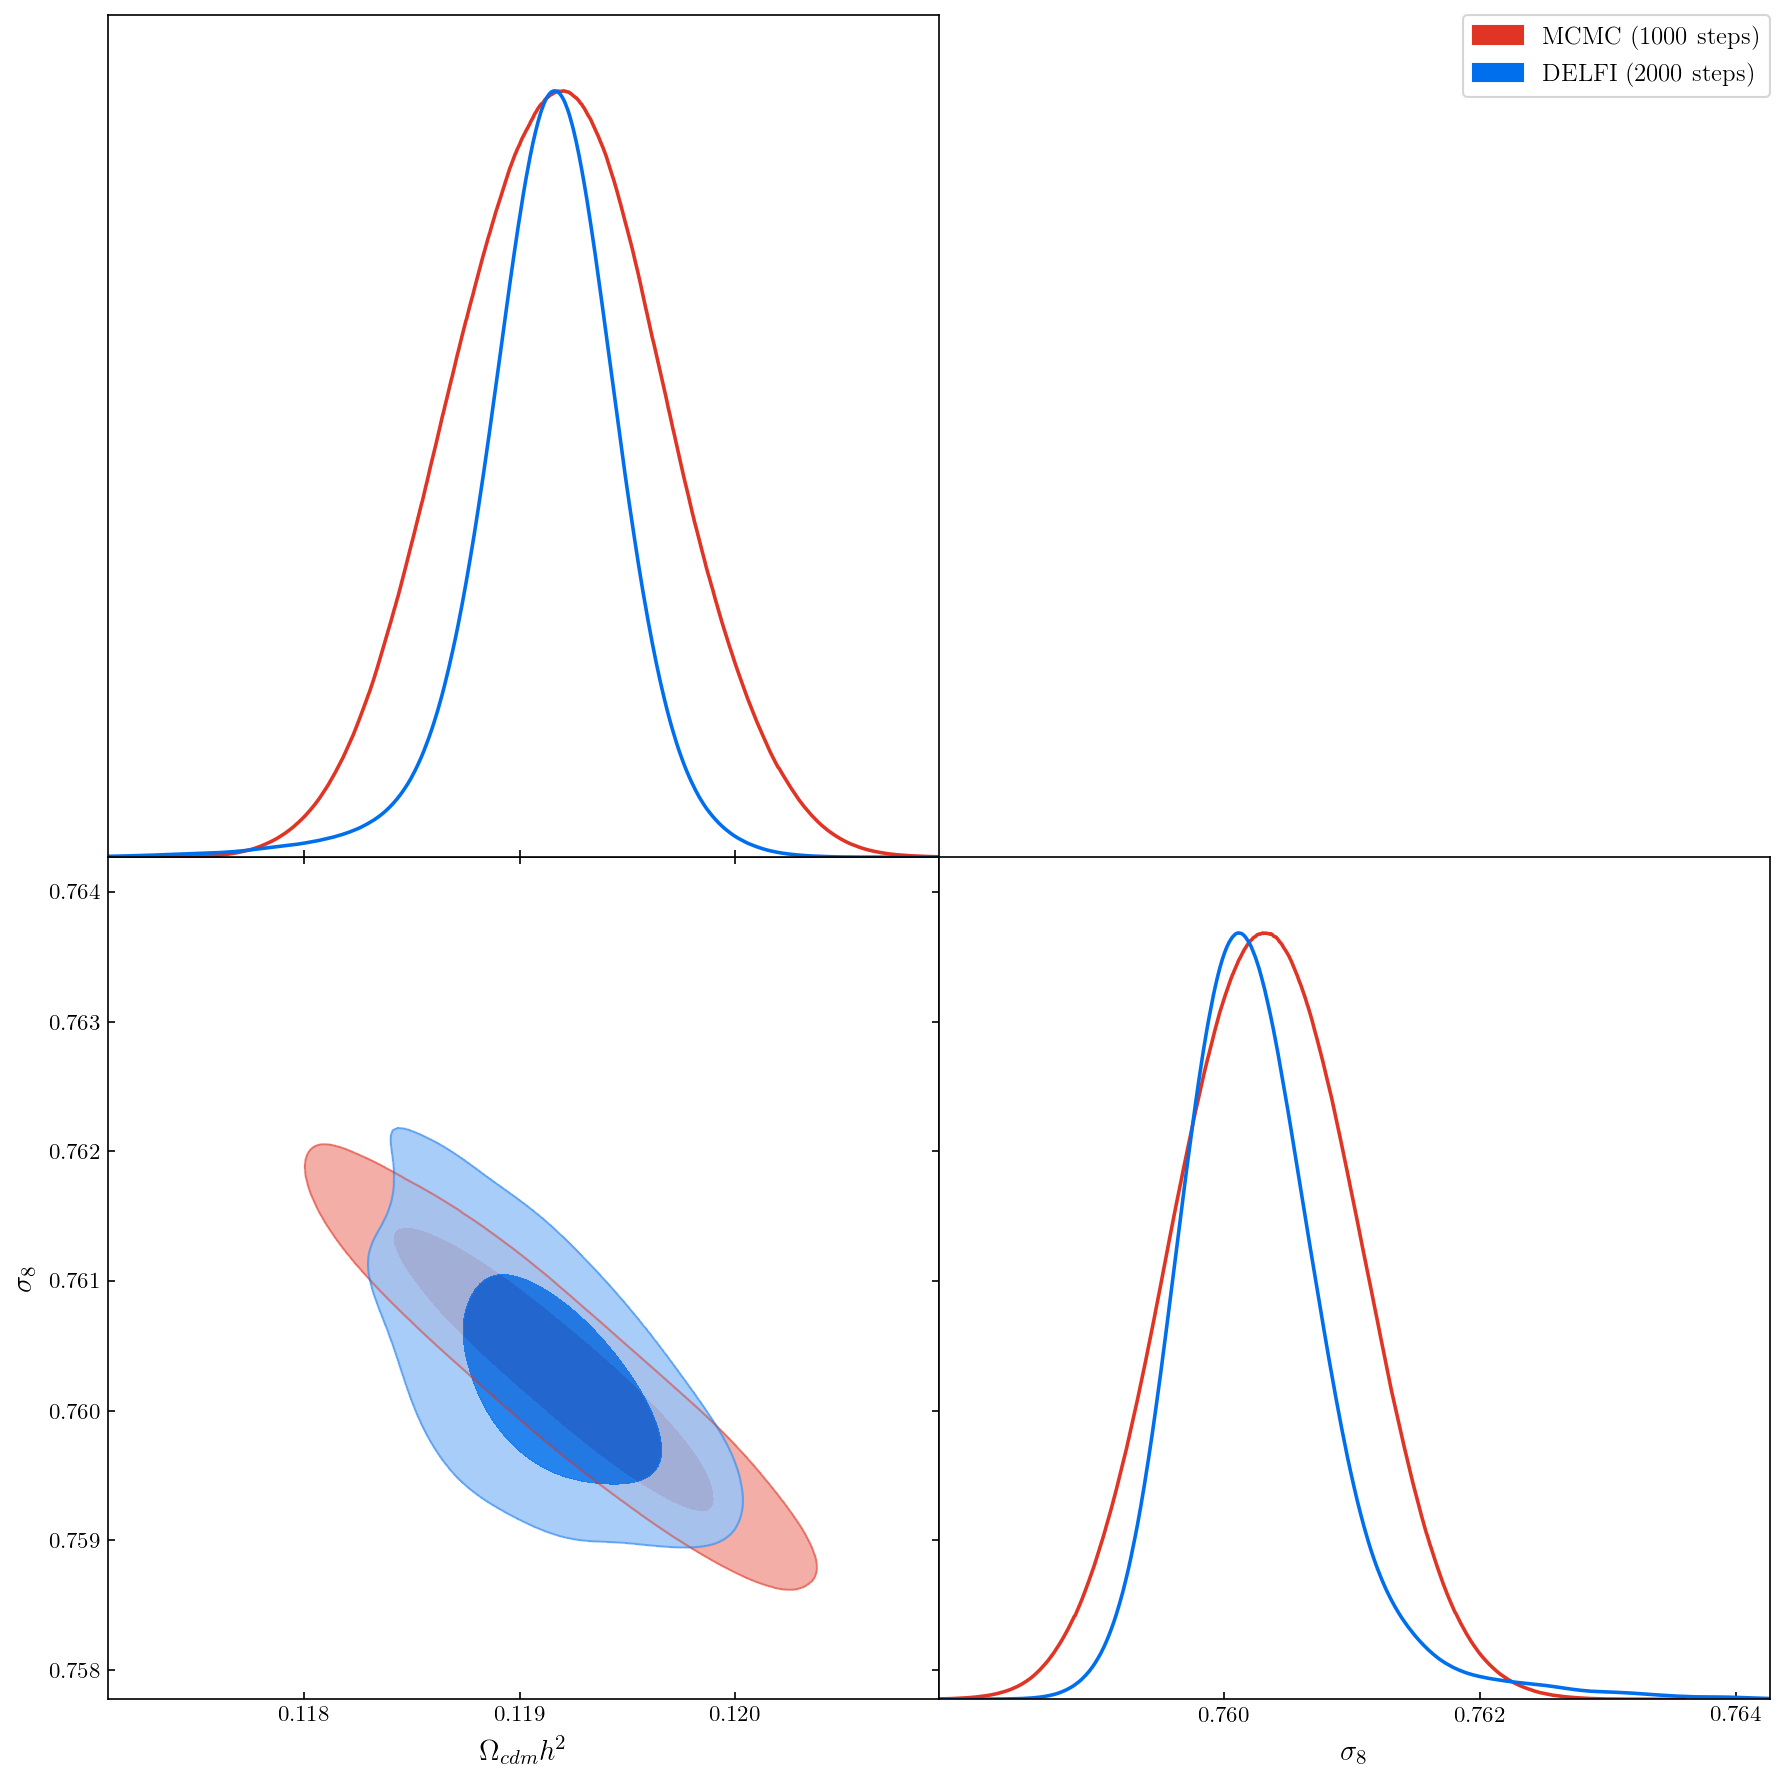

In [66]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI (2000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

In [88]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k_2/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k_2/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


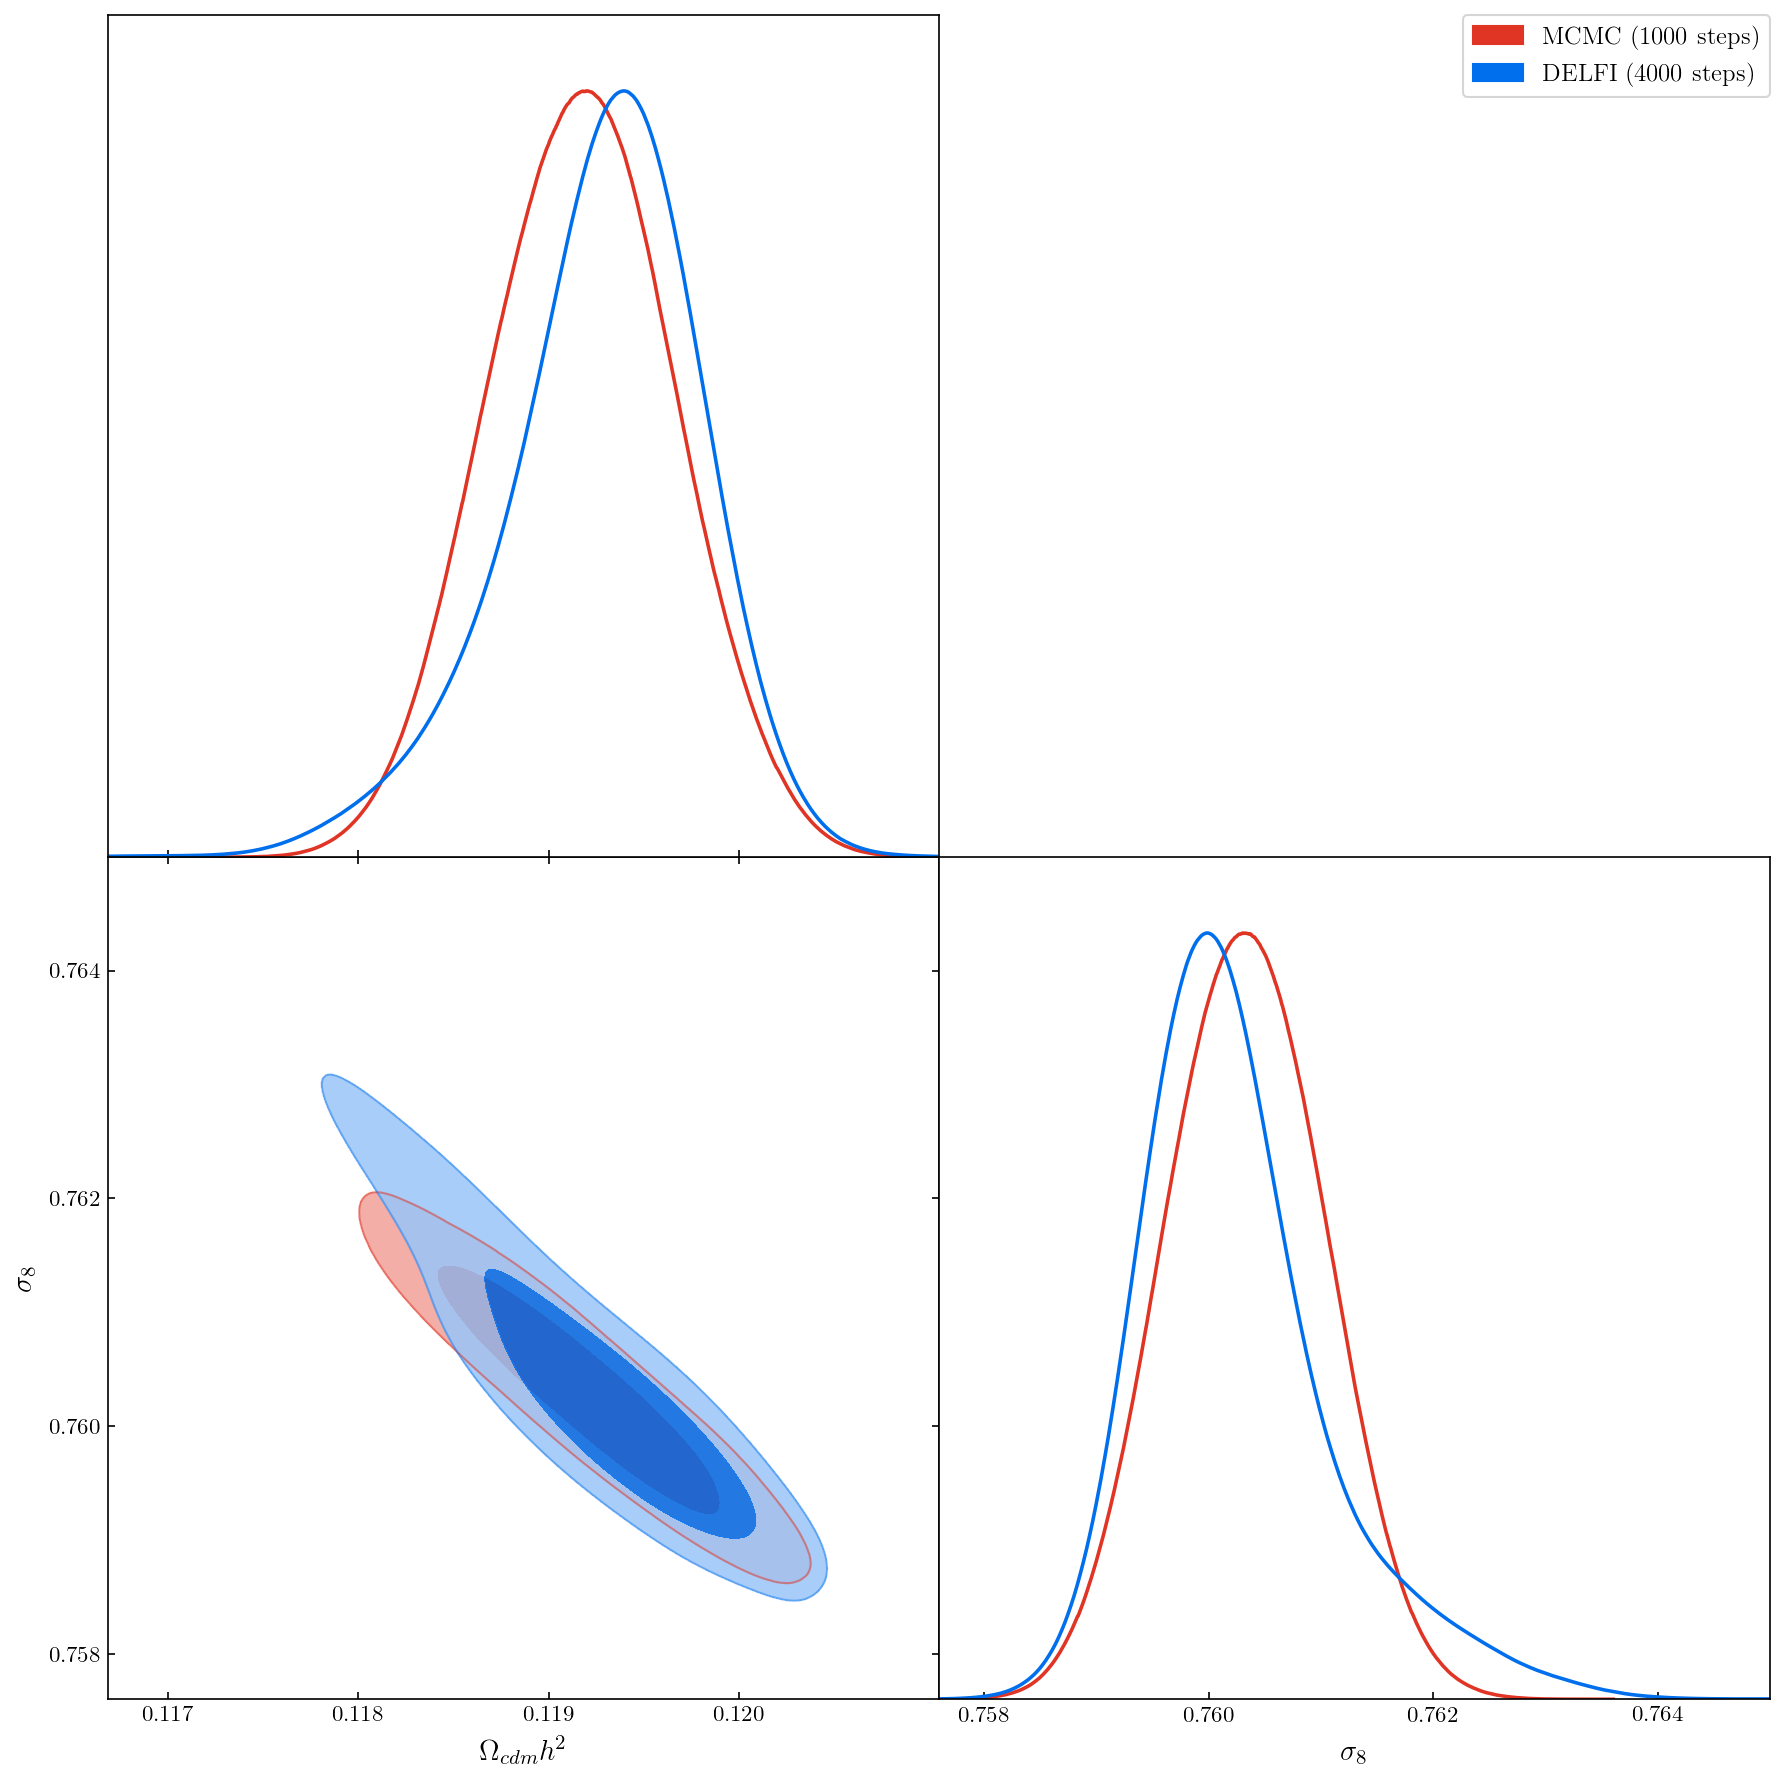

In [89]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI (4000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

In [86]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k_3/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_2k_3/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


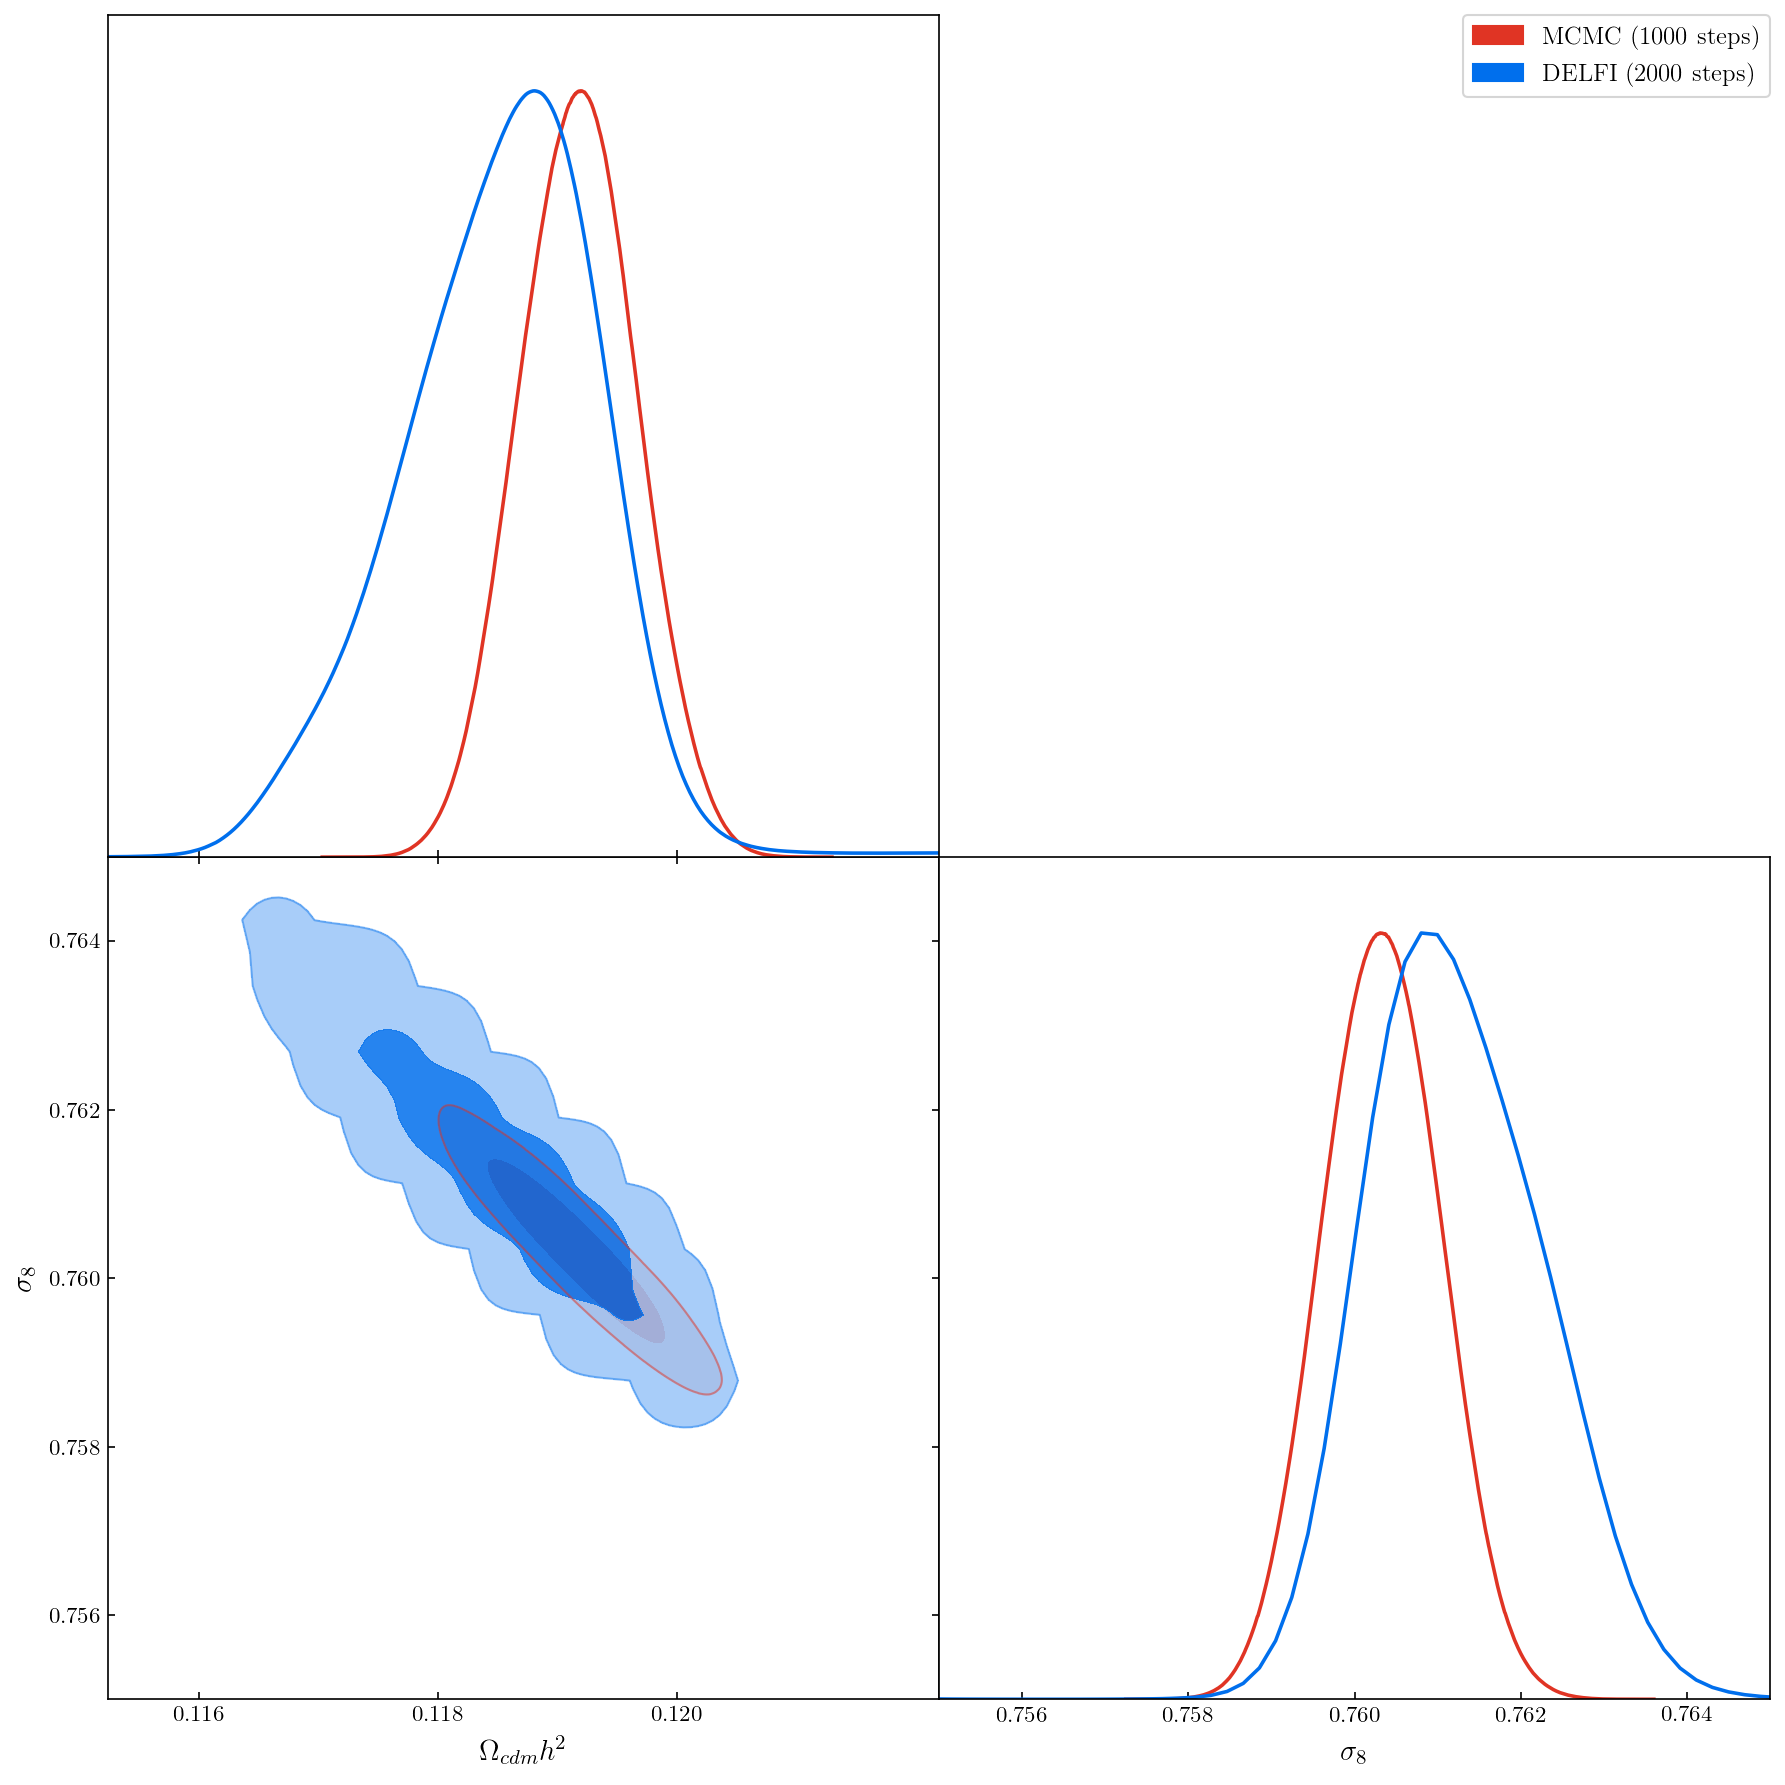

In [87]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI (2000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### $N_{steps}$ = 4000

In [69]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_4k/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_4k/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


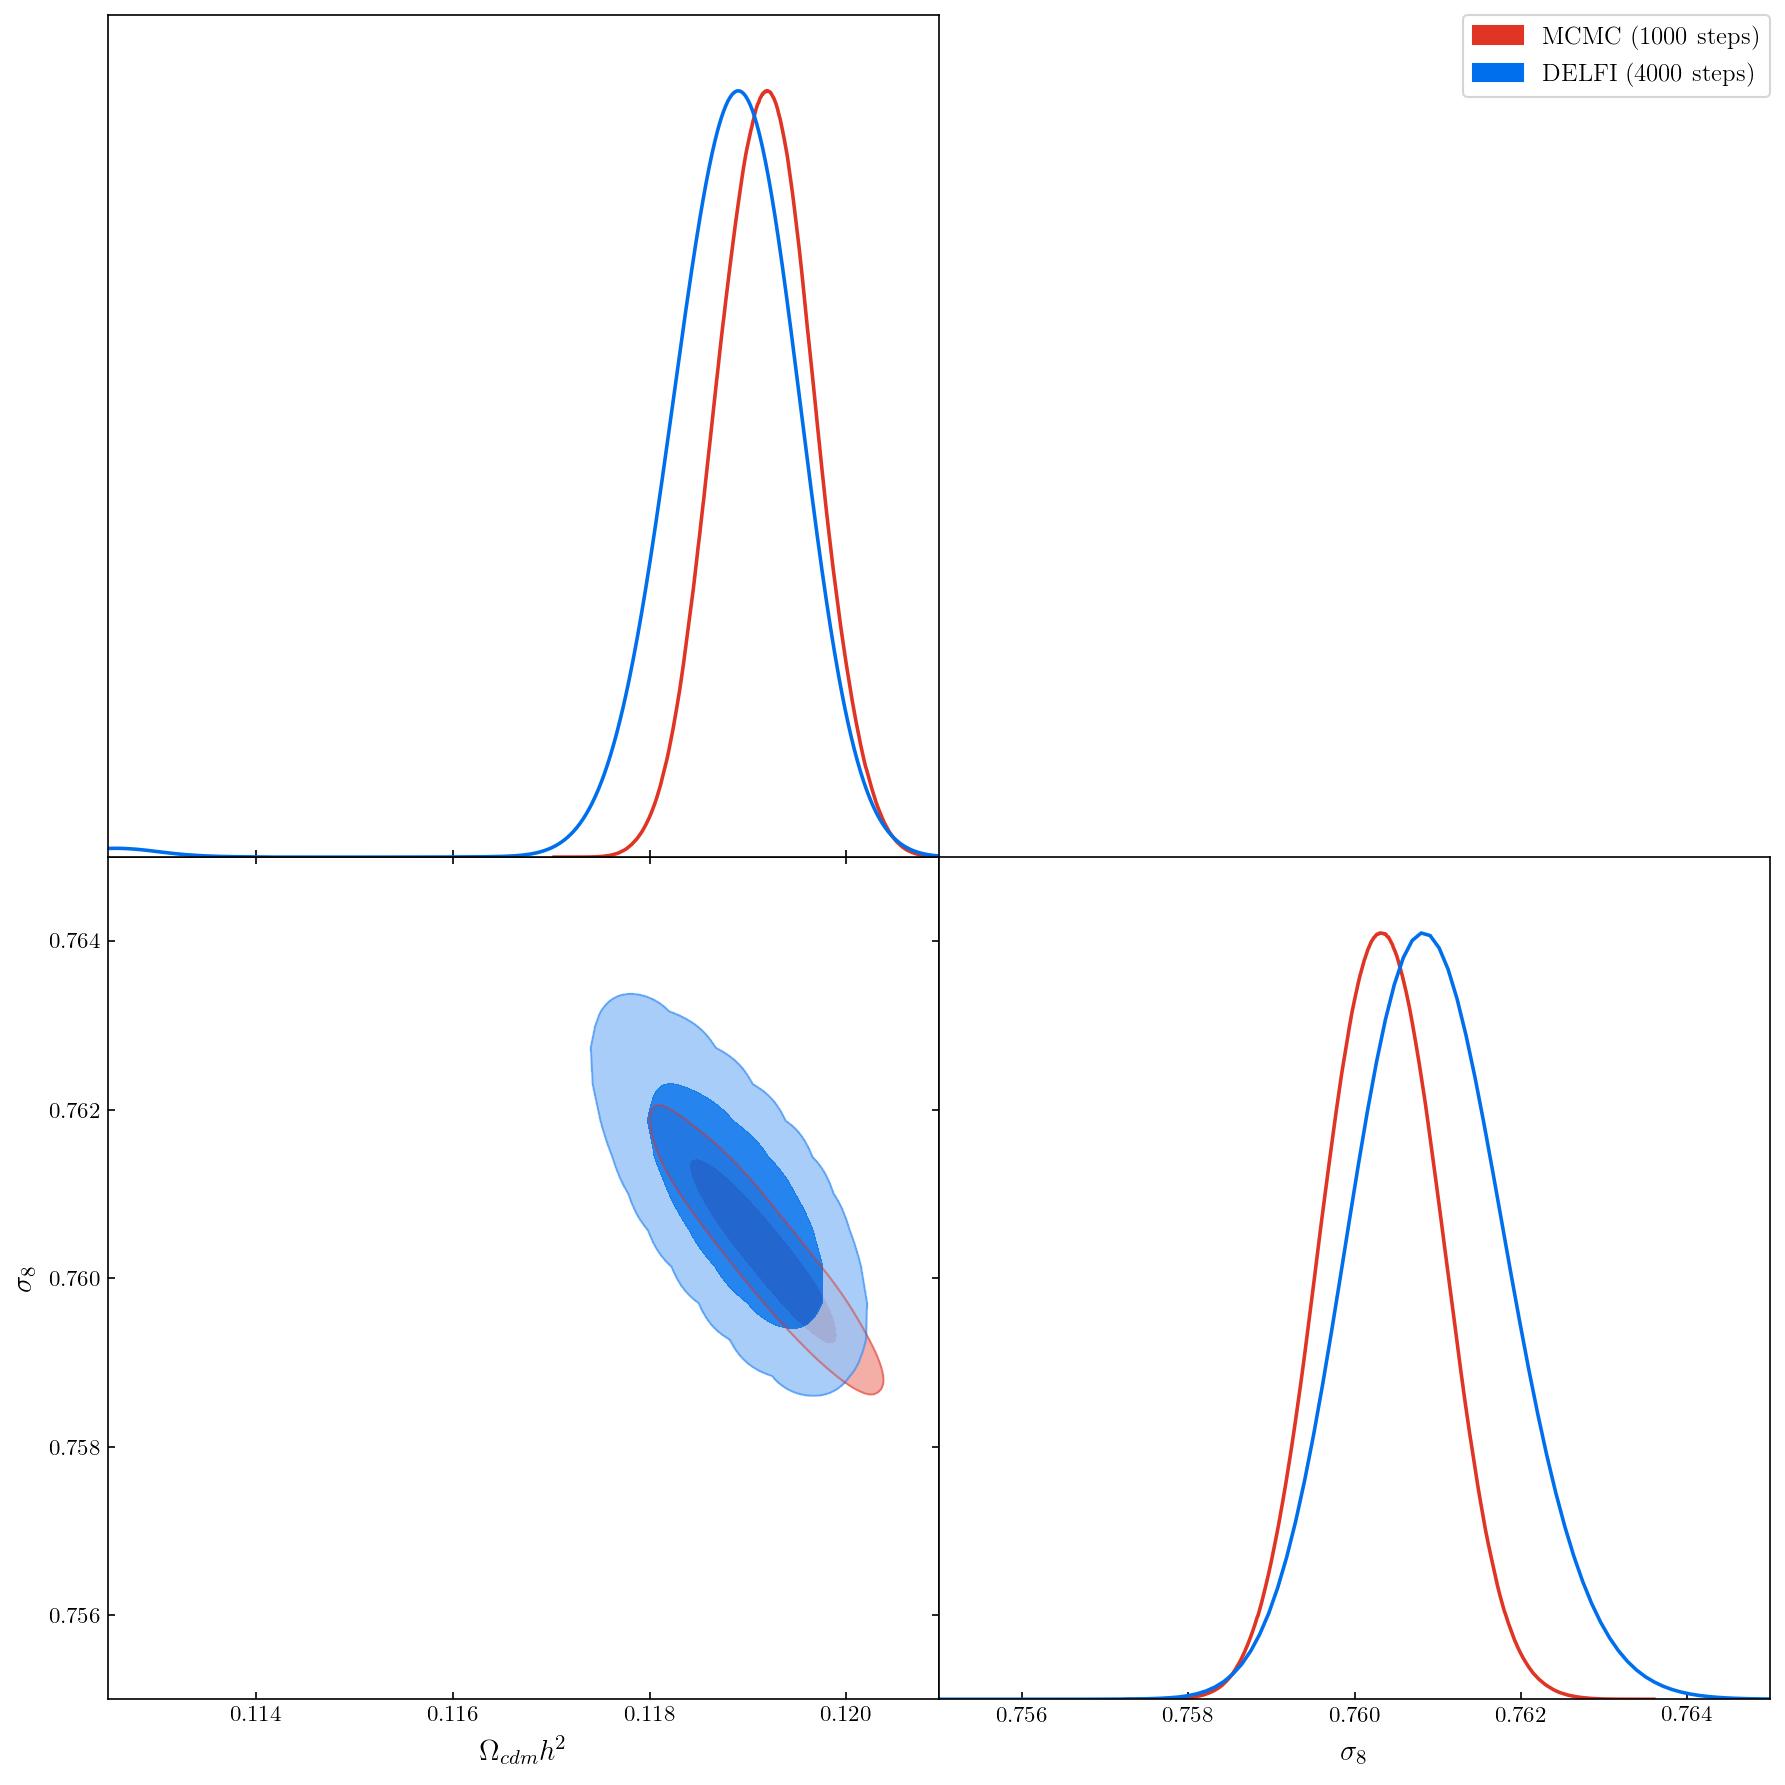

In [70]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI (4000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### With fisher pretraining + data compression, $N_{steps}$ = 1000

In [71]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_fisher_pretraining/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_seed1_interp_fisher_pretraining/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


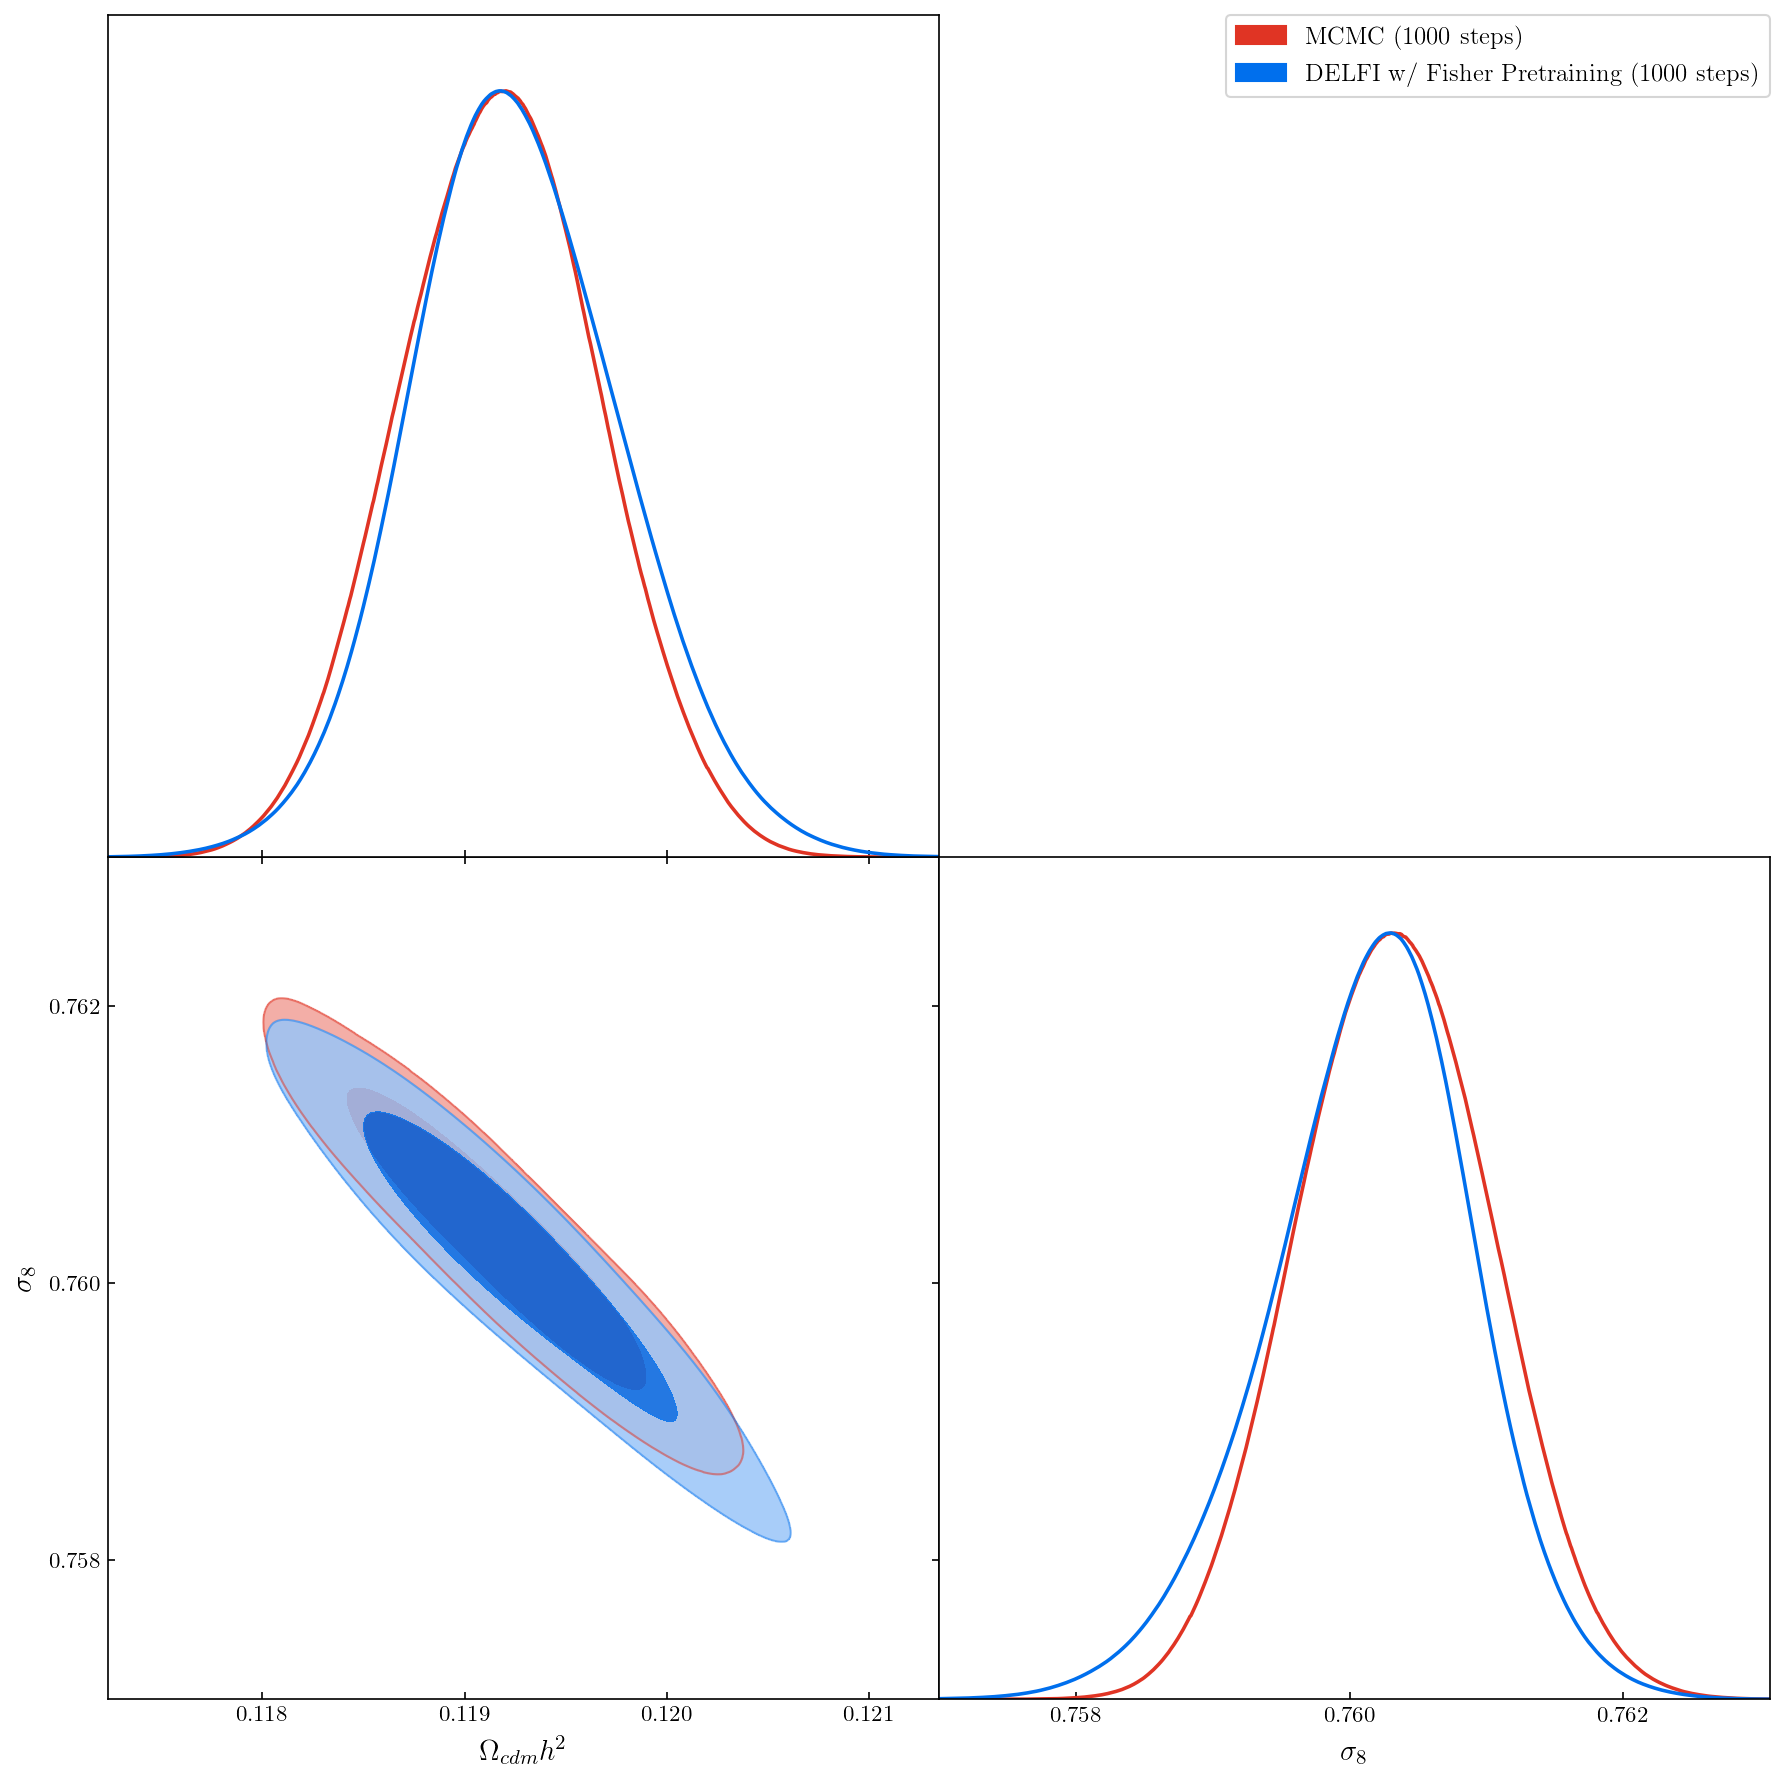

In [72]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI w/ Fisher Pretraining (1000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

## (1.3) data vector for $\omega_{cdm}$ = 0.1210, $\sigma_{8}$ = 0.72

#### load MCMC samples

In [73]:
flat_samples = np.load('flat_samples_1000_0_1210_0_72.npy')
flat_samples = [flat_samples]
mcmc_samples2 = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples)]

Removed no burn in


#### $N_{steps}$ = 1000

In [81]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_newThetaF/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_newThetaF/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


In [82]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_newThetaF2/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_newThetaF2/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_2 = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


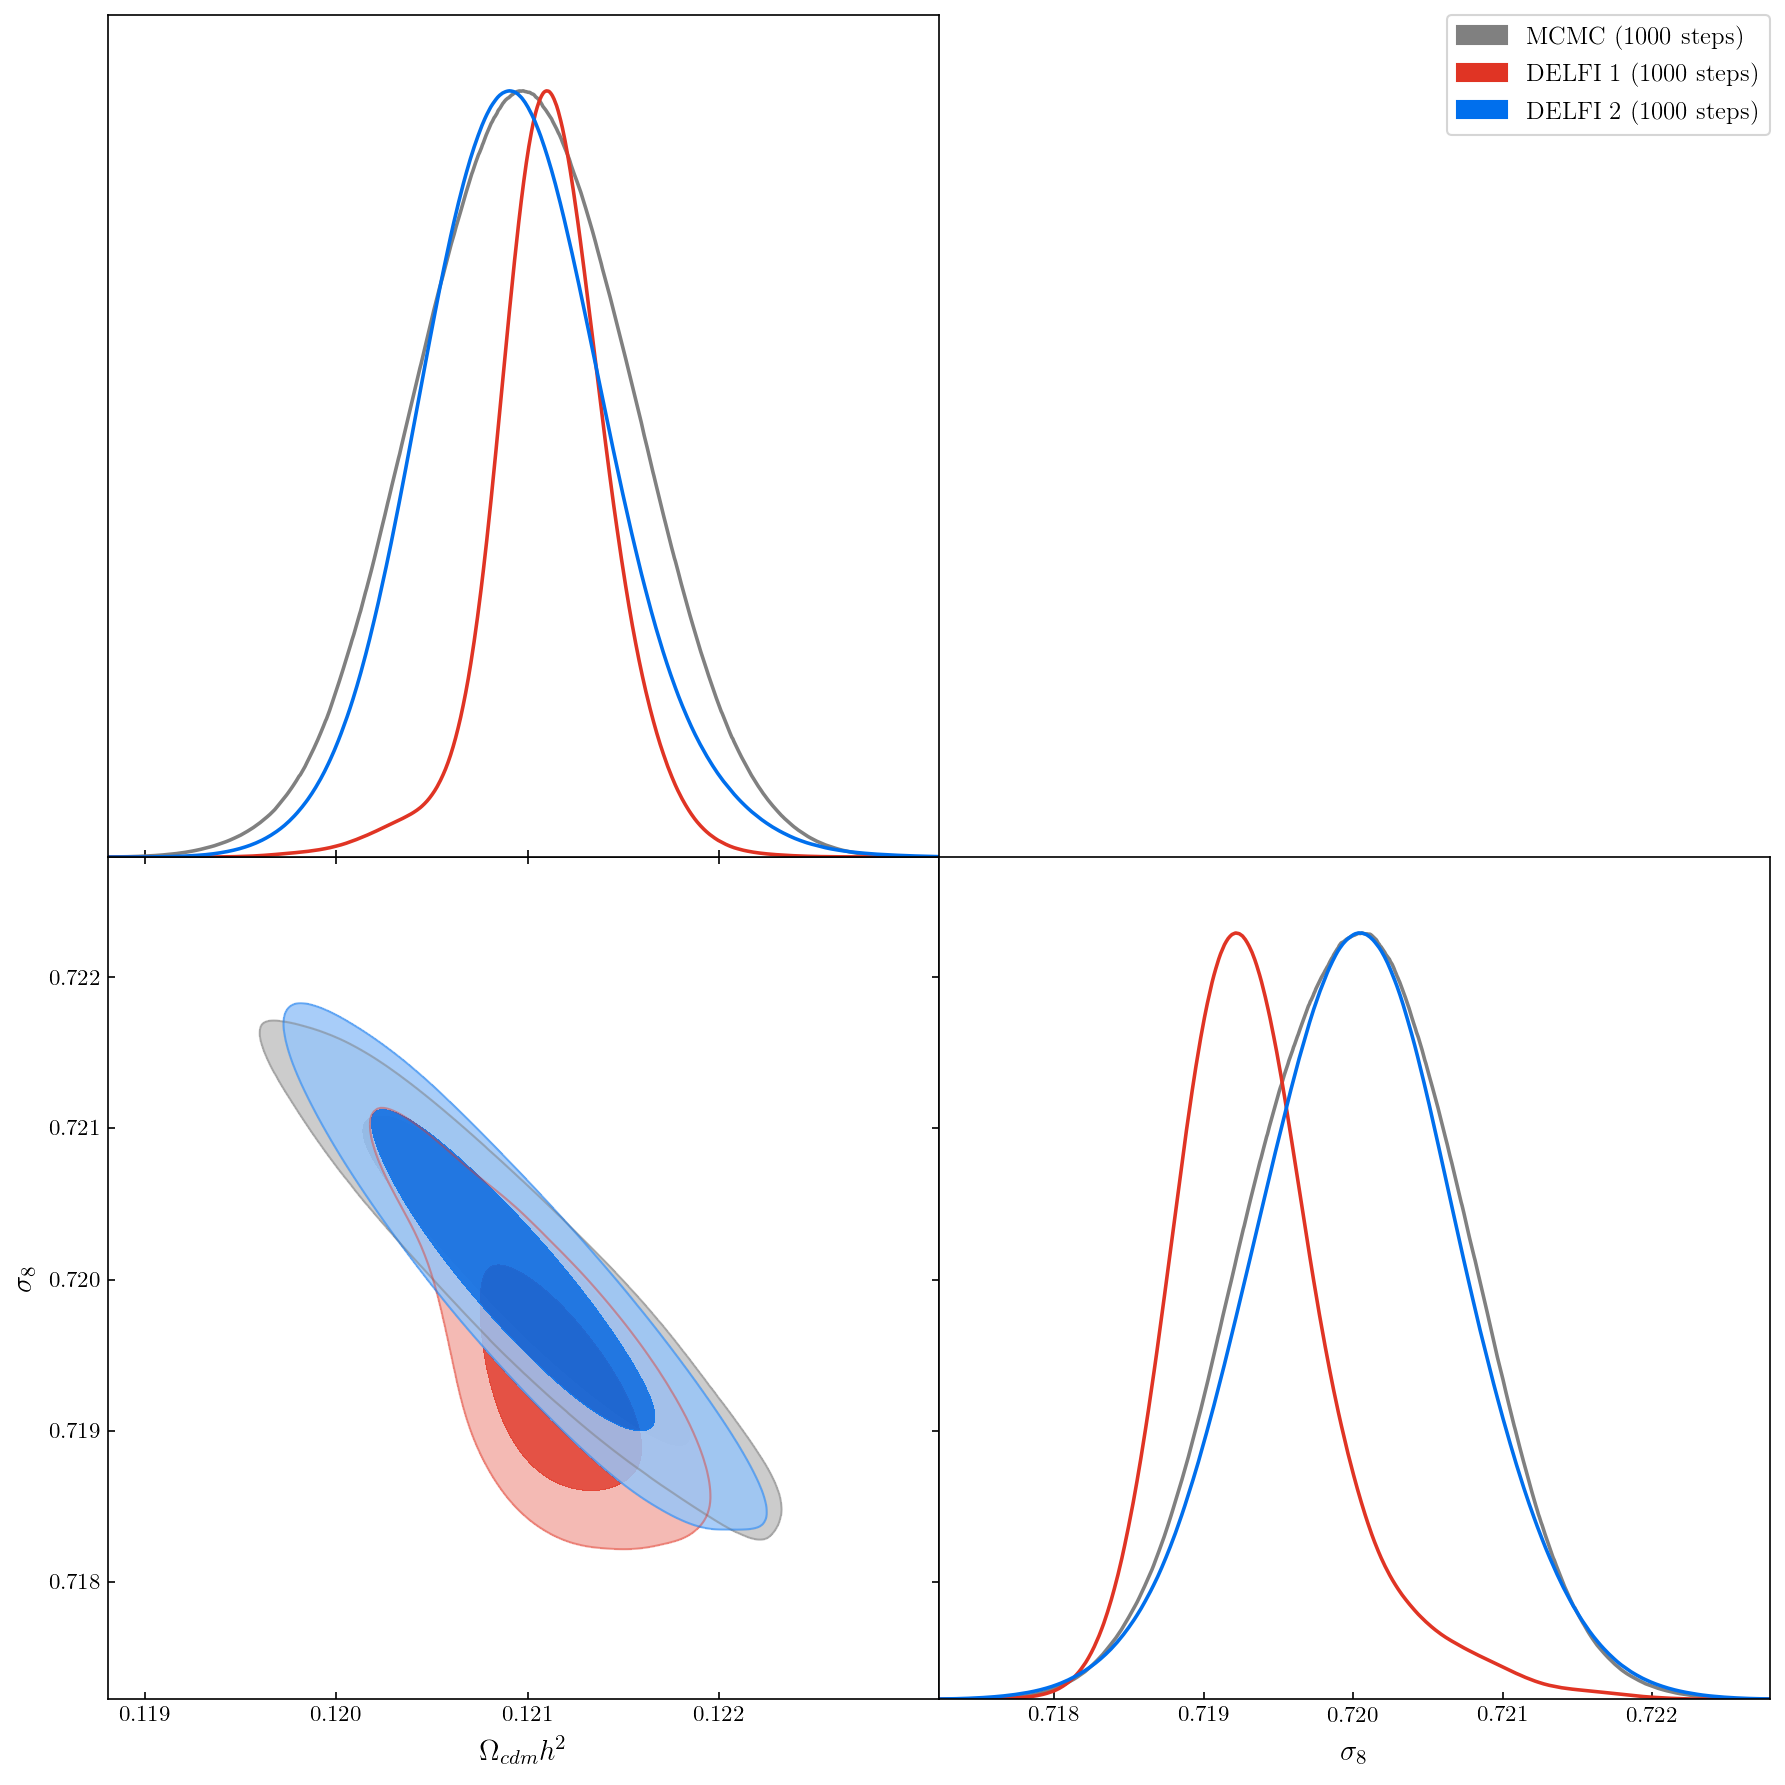

In [83]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples2[0], 
                 delfi_samples[0], 
                 delfi_samples_2[0]
                ], 
                legend_labels = ['MCMC (1000 steps)', 
                                 'DELFI 1 (1000 steps)',
                                 'DELFI 2 (1000 steps)'
                                ],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### With fisher pretraining + data compression, $N_{steps}$ = 1000

In [74]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_fisher_pretraining_0_1210_0_72/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_mock_trial_long_sims_interp_fisher_pretraining_0_1210_0_72/posterior_weights.npy')

samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


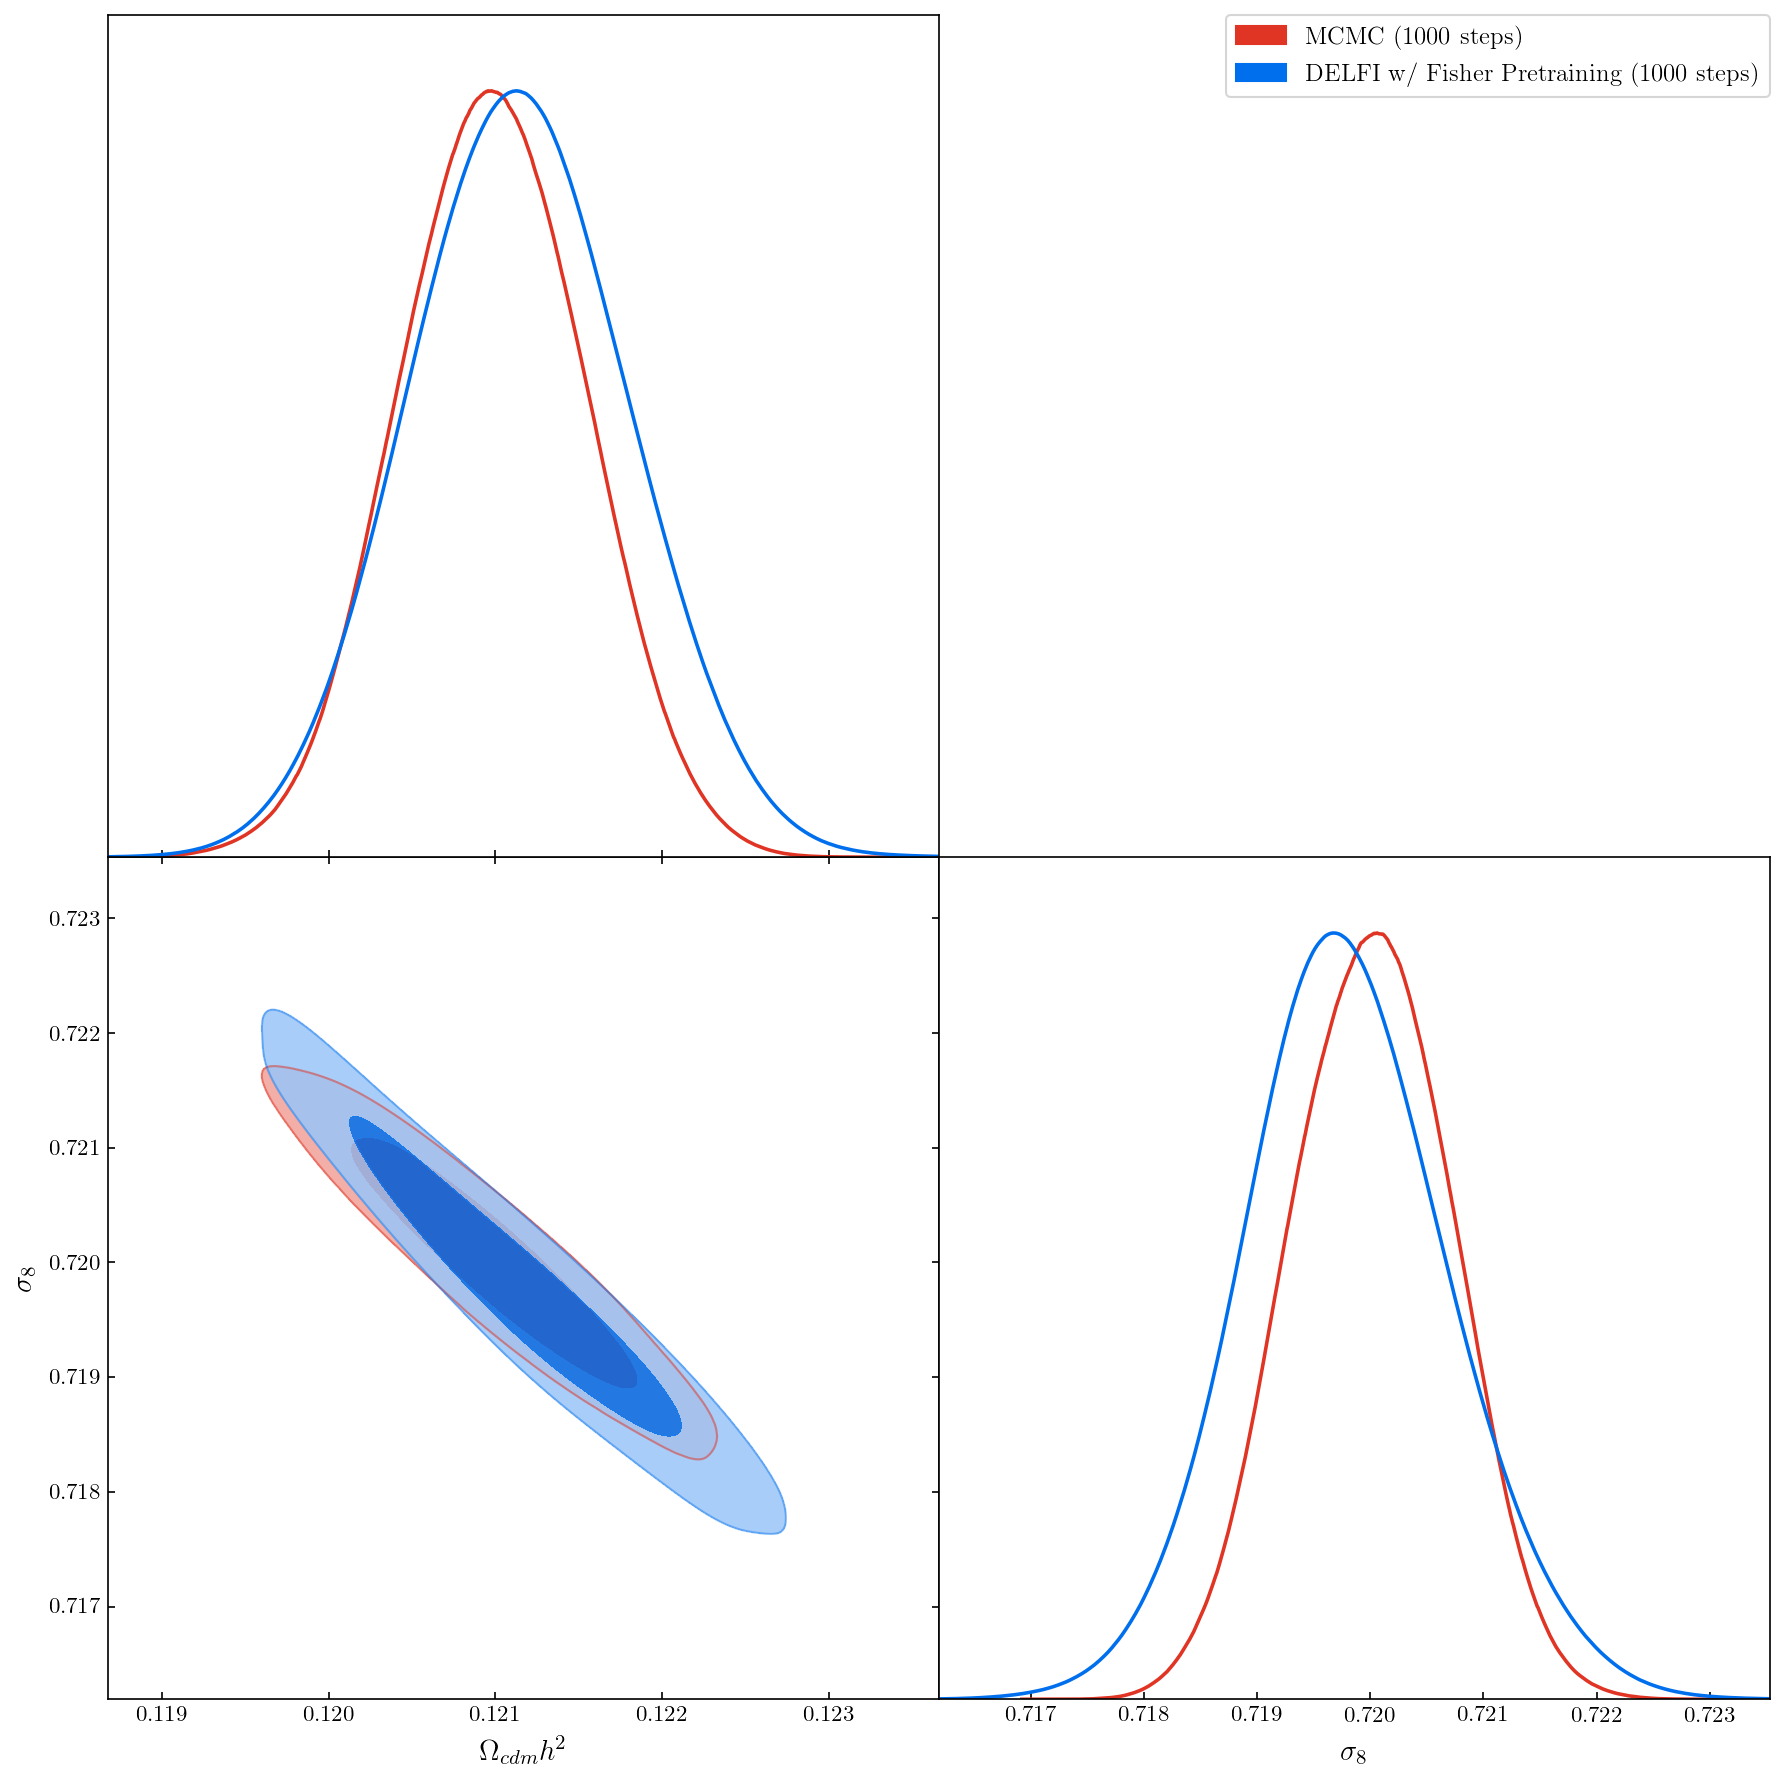

In [75]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples2[0], delfi_samples[0]], 
                legend_labels = ['MCMC (1000 steps)', 'DELFI w/ Fisher Pretraining (1000 steps)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)